# Three-Homolog, replicate fits

**Set the visible devices for GPU training**

In [1]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [2]:
# built-in libraries
import os
import sys
from itertools import combinations
from collections import defaultdict
import time
import pprint
import copy
from functools import reduce

# external dependencies
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
multidms.model.jax.config.update("jax_enable_x64", True)
# multidms.model.jax.config.update("jax_debug_nans", True)

# %load_ext autoreload
# %autoreload 2
# %matplotlib inline

**Read in the dms data and list all available experimental conditions**

In [3]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA1", "Omicron_BA2"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../data/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../data/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['condition'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}".replace('-Lib',''),
#     lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
func_score_data

preselection_sample library virus_batch  replicate  \
0   2021-10-28_thaw-1_VSVG_control_1   Lib-1      thaw-1          1   
1   2021-10-28_thaw-1_VSVG_control_2   Lib-1      thaw-1          2   
2   2021-10-28_thaw-1_VSVG_control_1   Lib-3      thaw-1          1   
3   2021-10-28_thaw-1_VSVG_control_2   Lib-3      thaw-1          2   
4   2021-10-28_thaw-1_VSVG_control_1   Lib-4      thaw-1          1   
5   2021-10-28_thaw-1_VSVG_control_2   Lib-4      thaw-1          2   
6   2021-10-28_thaw-1_VSVG_control_1   Lib-2      thaw-1          1   
7   2021-10-28_thaw-1_VSVG_control_2   Lib-2      thaw-1          2   
8   2022-03-25_thaw-1_VSVG_control_1   Lib-1      thaw-1          1   
9   2022-03-25_thaw-1_VSVG_control_2   Lib-1      thaw-1          2   
10  2022-06-22_thaw-1_VSVG_control_1   Lib-2      thaw-1          1   
11  2022-06-22_thaw-1_VSVG_control_1   Lib-3      thaw-1          1   
12  2022-10-22_thaw-1_VSVG_control_1   Lib-1      thaw-1          1   
13  2022-10-22_thaw-1_VSVG_control_1   Lib-2      thaw-1          1   
14  2022-10-22_thaw-2_VSVG_control_1   Lib-1      thaw-2          2   
15  2022-10-22_thaw-2_VSVG_control_1   Lib-2      thaw-2          2   

                       postselection_sample  \
0   2021-12-14_thaw-1_no-antibody_control_1   
1   2021-12-14_thaw-1_no-antibody_control_2   
2   2021-12-14_thaw-1_no-antibody_control_1   
3   2021-12-14_thaw-1_no-antibody_control_2   
4   2021-12-14_thaw-1_no-antibody_control_1   
5   2021-12-14_thaw-1_no-antibody_control_2   
6   2021-11-28_thaw-1_no-antibody_control_1   
7   2021-11-28_thaw-1_no-antibody_control_2   
8   2022-04-13_thaw-1_no-antibody_control_1   
9   2022-04-13_thaw-1_no-antibody_control_2   
10  2022-06-22_thaw-1_no-antibody_control_1   
11  2022-06-22_thaw-1_no-antibody_control_1   
12  2022-10-22_thaw-1_no-antibody_control_1   
13  2022-10-22_thaw-1_no-antibody_control_1   
14  2022-10-22_thaw-2_no-antibody_control_1   
15  2022-10-22_thaw-2_no-antibody_control_1   

               preselection_library_sample  \
0   Lib-1_2021-10-28_thaw-1_VSVG_control_1   
1   Lib-1_2021-10-28_thaw-1_VSVG_control_2   
2   Lib-3_2021-10-28_thaw-1_VSVG_control_1   
3   Lib-3_2021-10-28_thaw-1_VSVG_control_2   
4   Lib-4_2021-10-28_thaw-1_VSVG_control_1   
5   Lib-4_2021-10-28_thaw-1_VSVG_control_2   
6   Lib-2_2021-10-28_thaw-1_VSVG_control_1   
7   Lib-2_2021-10-28_thaw-1_VSVG_control_2   
8   Lib-1_2022-03-25_thaw-1_VSVG_control_1   
9   Lib-1_2022-03-25_thaw-1_VSVG_control_2   
10  Lib-2_2022-06-22_thaw-1_VSVG_control_1   
11  Lib-3_2022-06-22_thaw-1_VSVG_control_1   
12  Lib-1_2022-10-22_thaw-1_VSVG_control_1   
13  Lib-2_2022-10-22_thaw-1_VSVG_control_1   
14  Lib-1_2022-10-22_thaw-2_VSVG_control_1   
15  Lib-2_2022-10-22_thaw-2_VSVG_control_1   

                     postselection_library_sample  \
0   Lib-1_2021-12-14_thaw-1_no-antibody_control_1   
1   Lib-1_2021-12-14_thaw-1_no-antibody_control_2   
2   Lib-3_2021-12-14_thaw-1_no-antibody_control_1   
3   Lib-3_2021-12-14_thaw-1_no-antibody_control_2   
4   Lib-4_2021-12-14_thaw-1_no-antibody_control_1   
5   Lib-4_2021-12-14_thaw-1_no-antibody_control_2   
6   Lib-2_2021-11-28_thaw-1_no-antibody_control_1   
7   Lib-2_2021-11-28_thaw-1_no-antibody_control_2   
8   Lib-1_2022-04-13_thaw-1_no-antibody_control_1   
9   Lib-1_2022-04-13_thaw-1_no-antibody_control_2   
10  Lib-2_2022-06-22_thaw-1_no-antibody_control_1   
11  Lib-3_2022-06-22_thaw-1_no-antibody_control_1   
12  Lib-1_2022-10-22_thaw-1_no-antibody_control_1   
13  Lib-2_2022-10-22_thaw-1_no-antibody_control_1   
14  Lib-1_2022-10-22_thaw-2_no-antibody_control_1   
15  Lib-2_2022-10-22_thaw-2_no-antibody_control_1   

                                       selection_name  \
0   Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...   
1   Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...   
2   Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...   
3   Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...   
4   Lib-4_2021-10-28_thaw-1_VSVG_contro

**Define all the knobs which define the pipeline's pre-preprocessing behavior**

In [4]:
print(f"Available conditions for fitting are: {list(func_score_data.condition.unique())}")

Available conditions for fitting are: ['Delta-1', 'Delta-3', 'Delta-4', 'Delta-2', 'Omicron_BA1-1', 'Omicron_BA1-2', 'Omicron_BA1-3', 'Omicron_BA2-1', 'Omicron_BA2-2']


## Pre-Proccessing

In [5]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(condition=row.condition)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df = func_score_df.rename({"aa_substitutions_reference":"aa_substitutions"}, axis=1).reset_index(drop=True)
func_score_df.aa_substitutions.fillna("", inplace=True)
func_score_df.sort_values(by="condition", inplace=True)
func_score_df.info()

  0%|          | 0/16 [00:00<?, ?it/s]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1135096 entries, 0 to 1135095
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   library                      1135096 non-null  object 
 1   pre_sample                   1135096 non-null  object 
 2   post_sample                  1135096 non-null  object 
 3   barcode                      1135096 non-null  object 
 4   func_score                   1135096 non-null  float64
 5   func_score_var               1135096 non-null  float64
 6   pre_count                    1135096 non-null  int64  
 7   post_count                   1135096 non-null  int64  
 8   pre_count_wt                 1135096 non-null  int64  
 9   post_count_wt                1135096 non-null  int64  
 10  pseudocount                  1135096 non-null  float64
 11  n_codon_substitutions        1135096 non-null  int64  
 12  aa_substitutions_sequential  986419 non-nu

In [6]:
prep_params = {
    # pre-processing params
    "scale_counts" : False,
    "pseudocount" : 0.1,
    "sample" : False,
    "min_pre_counts" : 100,
    "clip_target" : (-3.5, 2.5),
    "trim" : False
}

**Optionally subset the variants**

In [7]:
if prep_params["sample"]:
    func_score_df = func_score_df.sample(prep_params["sample"])

In [8]:
func_score_df

library                        pre_sample  \
0         Lib-1  2021-10-28_thaw-1_VSVG_control_1   
60179     Lib-1  2021-10-28_thaw-1_VSVG_control_2   
60178     Lib-1  2021-10-28_thaw-1_VSVG_control_2   
60177     Lib-1  2021-10-28_thaw-1_VSVG_control_2   
60176     Lib-1  2021-10-28_thaw-1_VSVG_control_2   
...         ...                               ...   
930493    Lib-2  2022-10-22_thaw-1_VSVG_control_1   
930494    Lib-2  2022-10-22_thaw-1_VSVG_control_1   
930495    Lib-2  2022-10-22_thaw-1_VSVG_control_1   
930497    Lib-2  2022-10-22_thaw-1_VSVG_control_1   
1135095   Lib-2  2022-10-22_thaw-2_VSVG_control_1   

                                     post_sample           barcode  \
0        2021-12-14_thaw-1_no-antibody_control_1  CAAATTCATTATGTTC   
60179    2021-12-14_thaw-1_no-antibody_control_2  GAATGGTATGGCCGCG   
60178    2021-12-14_thaw-1_no-antibody_control_2  CTGTCTAACGCCTACC   
60177    2021-12-14_thaw-1_no-antibody_control_2  CGGCGTGACTCAATTC   
60176    2021-12-14_thaw-1_no-antibody_control_2  CGCACCAAAATTACAT   
...                                          ...               ...   
930493   2022-10-22_thaw-1_no-antibody_control_1  AAAGAACCAATACCTA   
930494   2022-10-22_thaw-1_no-antibody_control_1  AAAGAGTAGTTTATGC   
930495   2022-10-22_thaw-1_no-antibody_control_1  AAATATATGCCCAAAC   
930497   2022-10-22_thaw-1_no-antibody_control_1  AAATTAAGTTTGATAA   
1135095  2022-10-22_thaw-2_no-antibody_control_1  TTTTTGACGGACACCA   

         func_score  func_score_var  pre_count  post_count  pre_count_wt  \
0           -0.9244          0.0006      11079        5259       1187006   
60179        0.4364          0.0089        521         428       1154532   
60178       -1.8556          0.0278        521          87       1154532   
60177       -0.0470          0.0108        521         306       1154532   
60176        1.2236          0.0068        521         739       1154532   
...             ...             ...        ...         ...           ...   
930493      -0.7129          0.0183        287         187       9244303   
930494      -0.8500          0.0194        287         170       9244303   
930495      -2.3933          0.0428        287          58       9244303   
930497       0.6685          0.0115        287         488       9244303   
1135095     -0.6353          8.3255          0           0       6478978   

         post_count_wt  pseudocount  n_codon_substitutions  \
0              1069422          0.5                      4   
60179           701032          0.5                      7   
60178           701032          0.5                      5   
60177           701032          0.5                      1   
60176           701032          0.5                      3   
...                ...          ...                    ...   
930493         9882108          0.5                      4   
930494         9882108          0.5                      4   
930495         9882108          0.5                      2   
930497         9882108          0.5                      2   
1135095       10063399          0.5                      5   

                       aa_substitutions_sequential  n_aa_substitutions  \
0                         R212G N437- A844H L1242-                   4   
60179    L10V G75D Y447N R680W A827S A1018D V1226E                   7   
60178                       P25S Y363H A769N S811P                   4   
60177                                        R679S                   1   
60176                              V70N S98G V143I                   3   
...                                            ...                 ...   
930493                     P79S S109T D135T K1035N                   4   
930494                     L176P A219T G258H N402D                   4   
930495                                  S24F G410E                   2   
930497                                A219V S1239I                   2   
1135095              V16I Y498N G766C S940T I1127M        

**Drop all variants with pre-counts below a threshold.**

In [9]:
# Drop barcoded variants with pre-counts below a threshold
n_pre_threshold = len(func_score_df)
if prep_params["min_pre_counts"] == "bernadeta":
    func_score_df = func_score_df[func_score_df['pre_count'] >= func_score_df['pre_count_threshold']]
else:
    func_score_df = func_score_df[func_score_df['pre_count'] >= prep_params["min_pre_counts"]]

print(f"Of {n_pre_threshold} variants, {n_pre_threshold - len(func_score_df)} had fewer than the threshold of counts before selection, and were filtered out")

Of 1135096 variants, 120164 had fewer than the threshold of counts before selection, and were filtered out


In [10]:
func_score_df = func_score_df[['func_score', 'aa_substitutions', 'condition']].copy()

**remove all variants with string sites and stop codon wildtypes**

In [11]:
func_score_df.aa_substitutions.fillna("", inplace=True)
stop_wt_vars = []
non_numeric_sites = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    for sub in row["aa_substitutions"].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)
        if not sub[-2].isnumeric():
            non_numeric_sites.append(idx)

to_drop = set.union(set(stop_wt_vars), set(non_numeric_sites))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/1014932 [00:00<?, ?it/s]

In [12]:
if prep_params['clip_target'] and prep_params['trim']:
    l,h = prep_params['clip_target']
    func_score_trim = func_score_df.query(
        f"(func_score >= {l}) & (func_score <= {h})"
    )
    diff = len(func_score_df) - len(func_score_trim)
    print(f"Of {len(func_score_df)} variants, {diff} were thrown during trimming")
    func_score_df = func_score_trim

**Optionally, clip the target functional scores**

In [13]:
if prep_params['clip_target'] and not prep_params['trim']:
    func_score_df['func_score'] = func_score_df['func_score'].clip(*prep_params['clip_target'])

## Generate Replicate Datasets

**To analyze multiple datasets, we store the data object along with it's defining features in a dataframe.**

In [14]:
datasets = pd.DataFrame()

**Choose the libraries you would like in each of the two replicates**

In [15]:
rep1_name_map = {
    "Delta-3":"Delta", 
    "Omicron_BA1-2":"Omicron_BA1",
    "Omicron_BA2-1":"Omicron_BA2"
}
fs_rep1 = func_score_df.query("condition in @rep1_name_map.keys()").copy()
fs_rep1["condition"] = fs_rep1.condition.replace(rep1_name_map)

rep2_name_map = {
    "Delta-4":"Delta", 
    "Omicron_BA1-3":"Omicron_BA1",
    "Omicron_BA2-2":"Omicron_BA2"
}
fs_rep2 = func_score_df.query("condition in @rep2_name_map.keys()").copy()
fs_rep2["condition"] = fs_rep2.condition.replace(rep2_name_map)

for reference in ["Omicron_BA1"]: # can add 'Delta' if you would like to 
    for rep_fsdf in [fs_rep1, fs_rep2]:       
        
        start = time.time()
        data = multidms.MultiDmsData(
            rep_fsdf,
            alphabet= multidms.AAS_WITHSTOP_WITHGAP,
            condition_colors = sns.color_palette("colorblind"),
            reference=reference,
            assert_site_integrity = False,
            verbose=False
        )
        
        end = time.time()
        prep_time = round(end-start)
        print(f"Finished, time: {prep_time}")
        
        prep_params['conditions'] = tuple(rep_fsdf.condition.unique())
        prep_params['time_to_prep'] = prep_time
        prep_params['reference'] = reference
        data_row = pd.Series(prep_params).to_frame().T
        data_row['data'] = data
        datasets = pd.concat([datasets, data_row], ignore_index=True)
    

INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 37
INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
Finished, time: 36


In [16]:
# datasets.loc[0, "data"].params["β"][0]

In [17]:
import matplotlib.colors as colors

palette = [
    '#BFBFBF',#,'#404040',
    '#F97306',#, '#FFA500',
    '#9400D3'#, '#EE82EE',
]

conditions = [
    "Delta",# "Delta-3",
    "Omicron_BA1",# "Omicron_BA.1-3",
    "Omicron_BA2"#, "Omicron_BA.2-2"
]
cc = {con:tuple(colors.to_rgb(col)) for con, col in zip(conditions, palette)}

for row, values in datasets.iterrows():
    values.data.condition_colors = cc

In [148]:
def fit_wrapper(
    dataset,
    δ_huber = 1,
    λ_lasso_shift = 2e-5,
    λ_ridge_beta = 1e-6,
    λ_ridge_shift = 1e-6,
    λ_ridge_gamma = 1e-3,
    data_idx = 0,
    epistatic_model = "Identity",
    output_activation = "Identity",
    lock_beta = False, 
    lock_C_ref = False,
    gamma_corrected = True,
    conditional_c = False,
    init_C_ref = 0.0,
    warmup_beta = False,
    tol=1e-3,
    num_training_steps = 10,
    iterations_per_step = 2000,
    save_model_at = [2000, 10000, 20000],
    PRNGKey=0
):
    
    fit_attributes = locals().copy()
    biophysical_model = {
        "Identity" : multidms.model.identity_activation,
        "Sigmoid" : multidms.model.sigmoidal_global_epistasis,
        "Perceptron" : multidms.model.perceptron_global_epistasis,
        "Softplus" : multidms.model.softplus_activation,
        "GeLU" : multidms.model.gelu_activation
    }
    
    
    imodel = multidms.MultiDmsModel(
        dataset,
        epistatic_model=biophysical_model[fit_attributes['epistatic_model']],
        output_activation=biophysical_model[fit_attributes['output_activation']],
        conditional_c=fit_attributes['conditional_c'],
        gamma_corrected=fit_attributes['gamma_corrected'],
        init_C_ref=fit_attributes['init_C_ref'],
        PRNGKey=PRNGKey
    )

    if fit_attributes["warmup_beta"]:
        imodel.fit_reference_beta()

    lock_params = {}
    if fit_attributes["lock_beta"]:
        lock_params["β"] = imodel.params["β"]

    if fit_attributes["lock_C_ref"]:
        lock_params["C_ref"] = jnp.zeros(shape=(1,))

    fit_attributes['step_loss'] = onp.zeros(num_training_steps)
    print(f"running:")
    pprint.pprint(fit_attributes)

    total_iterations = 0
#     loss = onp.zeros(num_training_steps)
#     ret = pd.DataFrame()

#     model
    for training_step in range(num_training_steps):

        start = time.time()
        imodel.fit(
            lasso_shift = fit_attributes['λ_lasso_shift'],
            λ_ridge_shift = fit_attributes['λ_ridge_shift'],
            λ_ridge_beta = fit_attributes['λ_ridge_beta'],
            λ_ridge_gamma = fit_attributes['λ_ridge_beta'],
            maxiter=iterations_per_step, 
            tol=tol,
            δ=fit_attributes["δ_huber"],
            lock_params=lock_params
        )
        end = time.time()

        fit_time = round(end - start)
        total_iterations += iterations_per_step
        
        if onp.isnan(float(imodel.loss)):
            break
            
        fit_attributes['step_loss'][training_step] = float(imodel.loss)

        print(
            f"training_step {training_step}/{num_training_steps}, Loss: {imodel.loss}, Time: {fit_time} Seconds",
            flush=True
        )

        if total_iterations in save_model_at:
            fit_attributes[f"model_{total_iterations}"] = copy.copy(imodel)
              
    fit_series = pd.Series(fit_attributes).to_frame().T
#     ret = pd.concat([ret, data_row], ignore_index=True)
            
    return fit_series

    
def plot_loss_simple(models):

    fig, ax = plt.subplots(figsize=[7,7])
    iterations = [(i+1)*2000 for i in range(10)]
    for model, model_row in models.iterrows():

        loss = model_row['epoch_loss']

        ax.plot(
            iterations, 
            loss[0],
            lw=3,
            linestyle = "--",
            label=f"model: {model}"
        )

    ax.set_ylabel(f"Loss")
    ax.set_xlabel(f"Iterations")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.show()
    
def combine_replicate_muts(fit_dict, times_seen_threshold=3, agg_func=onp.mean):
    """
    Take a dictionary of fit objects, with key's as the prefix for individual
    replicate values, and merge then such that all individual and average mutation
    values are present in both.
    """

    # obtain and curate each of the replicate mutational dataframes
    mutations_dfs = []
    for replicate, fit in fit_dict.items():

        fit_mut_df = fit.mutations_df.set_index("mutation")

        new_column_name_map = {c: f"{replicate}_{c}" for c in fit_mut_df.columns}
        fit_mut_df = fit_mut_df.rename(new_column_name_map, axis=1)

        times_seen_cols = [c for c in fit_mut_df.columns if "times" in c]
        for c in times_seen_cols:
            fit_mut_df = fit_mut_df[fit_mut_df[c] >= times_seen_threshold]
        mutations_dfs.append(fit_mut_df)

    # merge each of the replicate mutational dataframes
    mut_df = reduce(
        lambda left, right: pd.merge(
            left, right, left_index=True, right_index=True, how="inner"
        ),
        mutations_dfs,
    )
    
    if agg_func is None:
        return mut_df

    column_order = []
    # now compute replicate averages
    for c in fit.mutations_df.columns:
        if c == "mutation" or "times_seen" in c:
            continue
        cols_to_combine = [f"{replicate}_{c}" for replicate in fit_dict.keys()]

        # just keep one replicate wt, site, mut .. as they are shared.
        if c in ["wts", "sites", "muts"]:
            mut_df[c] = mut_df[cols_to_combine[0]]
            mut_df.drop(cols_to_combine, axis=1, inplace=True)

        # take the average.
        else:
            mut_df[f"{c}"] = mut_df[cols_to_combine].apply(agg_func, axis=1)
            column_order += (cols_to_combine + [f"{c}"])

    return mut_df.loc[:, ["wts", "sites", "muts"] + column_order]


In [19]:
onp.isnan(float(onp.nan))

True

In [20]:
datasets

scale_counts pseudocount sample min_pre_counts  clip_target   trim  \
0        False         0.1  False            100  (-3.5, 2.5)  False   
1        False         0.1  False            100  (-3.5, 2.5)  False   

                          conditions time_to_prep    reference  \
0  (Delta, Omicron_BA1, Omicron_BA2)           37  Omicron_BA1   
1  (Delta, Omicron_BA1, Omicron_BA2)           36  Omicron_BA1   

                                                data  
0  <multidms.data.MultiDmsData object at 0x7fcaac...  
1  <multidms.data.MultiDmsData object at 0x7fcaac...

In [21]:
# datasets.loc[0, "data"].training_data['y']['Delta']

In [22]:
models = pd.DataFrame()

In [23]:
# Compare global epistasis models

In [39]:
models

dataset δ_huber λ_lasso_shift  \
0   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
1   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
2   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
3   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
4   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
5   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
6   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
7   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
8   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
9   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
10  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
11  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
12  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
13  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
14  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
15  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
16  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
17  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
18  <multidms.data.MultiDmsData object at 0x7fcaac...       1           0.0   
19  <multidms.data.MultiDmsData object at 0x7fcaac...       1           0.0   
20  <multidms.data.MultiDmsData object at 0x7fcaac...       1      0.000002   
21  <multidms.data.MultiDmsData object at 0x7fcaac...       1      0.000002   
22  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
23  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
24  <multidms.data.MultiDmsData object at 0x7fcaac...       1        0.0002   
25  <multidms.data.MultiDmsData object at 0x7fcaac...       1        0.0002   
26  <multidms.data.MultiDmsData object at 0x7fcaac...       1         0.002   
27  <multidms.data.MultiDmsData object at 0x7fcaac...       1         0.002   

   λ_ridge_beta λ_ridge_shift λ_ridge_gamma data_idx epistatic_model  \
0             0             0         0.001        0        Identity   
1             0             0         0.001        0        Identity   
2             0             0         0.001        0        Identity   
3             0             0         0.001        0        Identity   
4             0             0         0.001        0        Identity   
5             0             0         0.001        0        Identity   
6             0             0         0.001        0         Sigmoid   
7             0             0         0.001        0         Sigmoid   
8             0             0         0.001        0         Sigmoid   
9             0             0         0.001        0         Sigmoid   
10            0             0         0.001        0         Sigmoid   
11            0             0         0.001        0         Sigmoid   
12            0             0         0.001        0      Perceptron   
13            0             0         0.001        0      Perceptron   
14            0             0         0.001        0      Perceptron   
15            0             0         0.001        0      Perceptron   
16            0             0         0.001        0      Perceptron   
17            0             0         0.001        0      Perceptron   
18            0             0         0.001        0         Sigmoid   
19            0             0         0.001        0         Sigmoid   
20            0             0         0.001        0         Sigmoid   
21            0             0         0.001        0         Sigmoid   
22            0             0         0.001        0         Sigmoid   
23            0           

In [26]:
fit_iter = 0
for ge in ["Identity", "Sigmoid", "Perceptron"]:
    for output in ["Identity", "Softplus", "GeLU"]:
        for replicate in datasets.index.values:
            
            if fit_iter in range(0, 14):
                fit_iter += 1
                continue

            new = {
                'epistatic_model' : ge,
                'output_activation' : output,
                'warmup_beta':True,
                'λ_ridge_beta':0,
                'λ_ridge_shift':0,
                'λ_ridge_gamma':1e-3,
                'tol':1e-6,
                'save_model_at':[2000, 10000, 40000],
                'num_training_steps': 20,
                'iterations_per_step':2000
            }
            start_t = time.time()
            model = fit_wrapper(datasets.loc[replicate, "data"], **new)
            model['replicate'] = replicate
            models = pd.concat([models, model])
            end_t = time.time()
            fit_iter += 1
            print(f"Done with {fit_iter}/18! Total time: {round(end_t - start_t)}")
            print("------------------------------------------")


running:
{'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7fcaac96bf70>,
 'epistatic_model': 'Perceptron',
 'gamma_corrected': True,
 'init_C_ref': 0.0,
 'iterations_per_step': 2000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 20,
 'output_activation': 'Softplus',
 'save_model_at': [2000, 10000, 40000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': True,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 0}
training_step 0/20, Loss: 0.730502796769495, Time: 34 Seconds
training_step 1/20, Loss: 0.699958124014652, Time: 31 Seconds
training_step 2/20, Loss: 0.6876900784449972, Time: 31 Seconds
training_step 3/20, Loss: 0.6802470087122923, Time: 31 Seconds
training_step 4/20, Loss: 0.677013678444078, Time: 31 Seconds
training_step 5/20, Loss: 0.6736197633675124, Time: 30 Seconds
t

In [27]:
output_color_dict = {
    "Identity" : "purple",
    "Softplus" : "blue",
    "GeLU" : "darkgreen"
}

replicate_style_dict = {
    0 : "--",
    1 : "-"
}

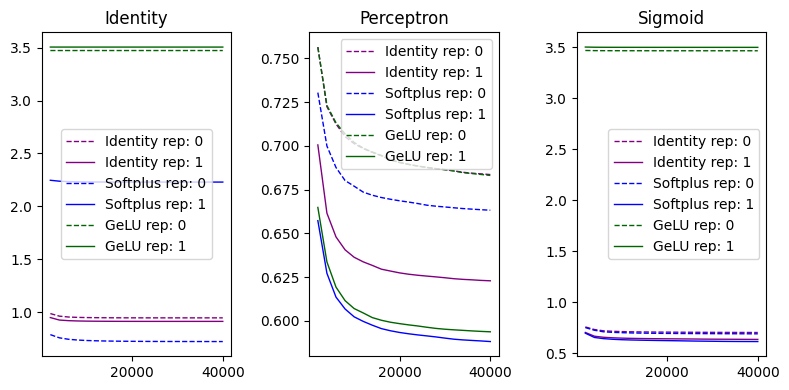

In [28]:
fig, ax = plt.subplots(1,3,figsize=[8,4], sharex=True, sharey=False)
for i, (group, group_models) in enumerate(models.groupby('epistatic_model')):
    
    for model, model_row in group_models.iterrows():
        ax[i].plot(
            [2000 * (s+1) for s in range(len(model_row.step_loss))],
            model_row.step_loss,
            lw=1,
            color = output_color_dict[model_row.output_activation],
            linestyle= replicate_style_dict[model_row.replicate],
            label=f"{model_row.output_activation} rep: {model_row.replicate}"
        )
    ax[i].set_title(group)
    ax[i].legend()
plt.tight_layout()
plt.show()

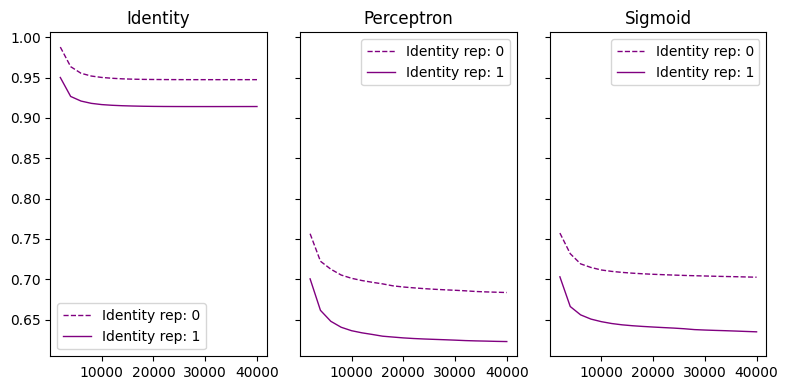

In [29]:
fig, ax = plt.subplots(1,3,figsize=[8,4], sharex=True, sharey=True)
for i, (group, group_models) in enumerate(
    models.query("output_activation == 'Identity'").groupby('epistatic_model')
):
    
    for model, model_row in group_models.iterrows():
        ax[i].plot(
            [2000 * (s+1) for s in range(len(model_row.step_loss))],
            model_row.step_loss,
            lw=1,
            color = output_color_dict[model_row.output_activation],
            linestyle= replicate_style_dict[model_row.replicate],
            label=f"{model_row.output_activation} rep: {model_row.replicate}"
        )
    ax[i].set_title(group)
    ax[i].legend()
plt.tight_layout()
plt.show()

## TODO


* How do the distributions change over iterations 2k, 10k, and 40k? Violin plots ...
* sensitivity analysis
* Link to the 64 bit notebook?
* How do the distributions change over iterations 2k, 10k, and 40k? Violin plots ...
* Seed certainty analysis!
* replicate correlation

Group models into rows (global epistasis models) and columns (output activation) for plotting:
1. parameter distrubtions through time
2. replicate correlation of parameters.

In [31]:
mod = models.loc[0, "model_40000"]
shift_params = [f"S_{c}" for c in mod.data.conditions if c != mod.data.reference]

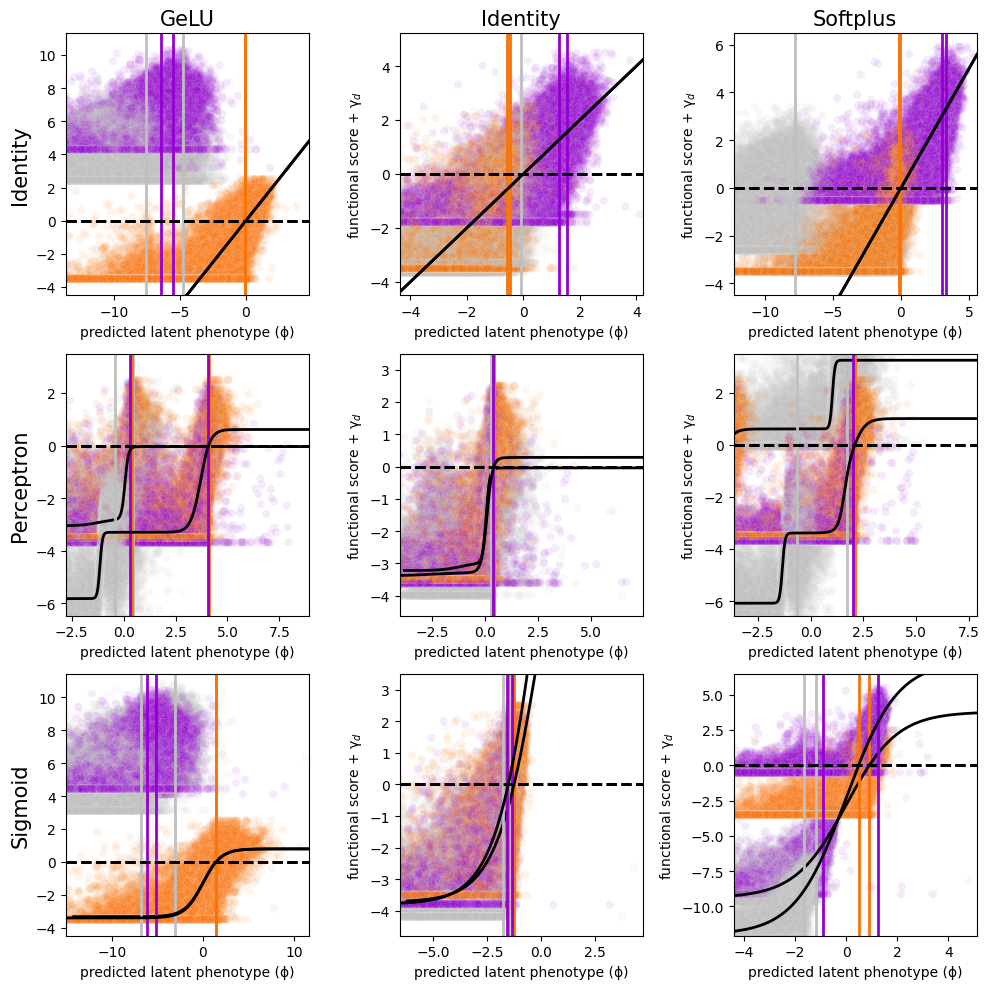

In [49]:
fig, ax = plt.subplots(3,3,figsize=[10,10], sharex=False, sharey=False)
for row, (gep, gep_models) in enumerate(models.loc[0:17].groupby('epistatic_model')):   

    for col, (out, out_models) in enumerate(gep_models.groupby('output_activation')):
        # we should only have two replicates
        assert len(out_models) == 2
        for model, model_row in out_models.iterrows():
            # the failed fits are NaN
            if type(model_row.model_40000) == multidms.MultiDmsModel:
                model_row.model_40000.plot_epistasis(
                    ax=ax[row, col], show=False, alpha=0.08, legend=False, 
                )
        if col == 0: ax[row, col].set_ylabel(gep, size=15)
        if row == 0: ax[row, col].set_title(out, size=15)
#         ax[i].set_title(group)
#         ax[i].legend()
plt.tight_layout()
plt.show()
fig.savefig("Vanilla-Delta-3-4.png")

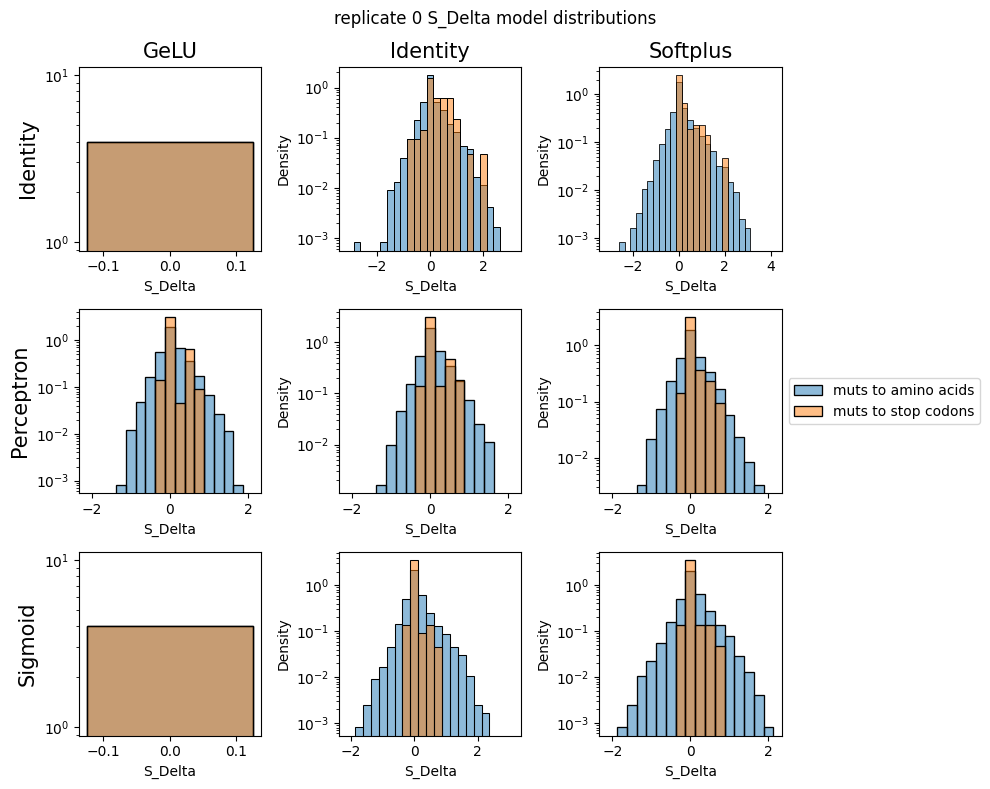

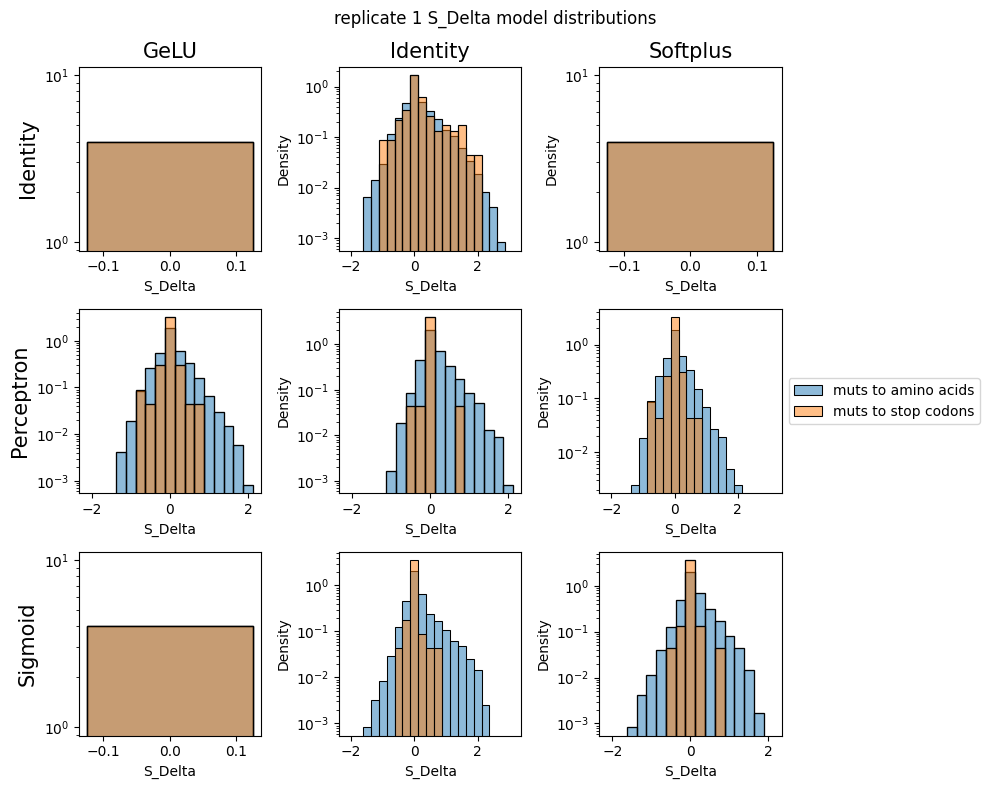

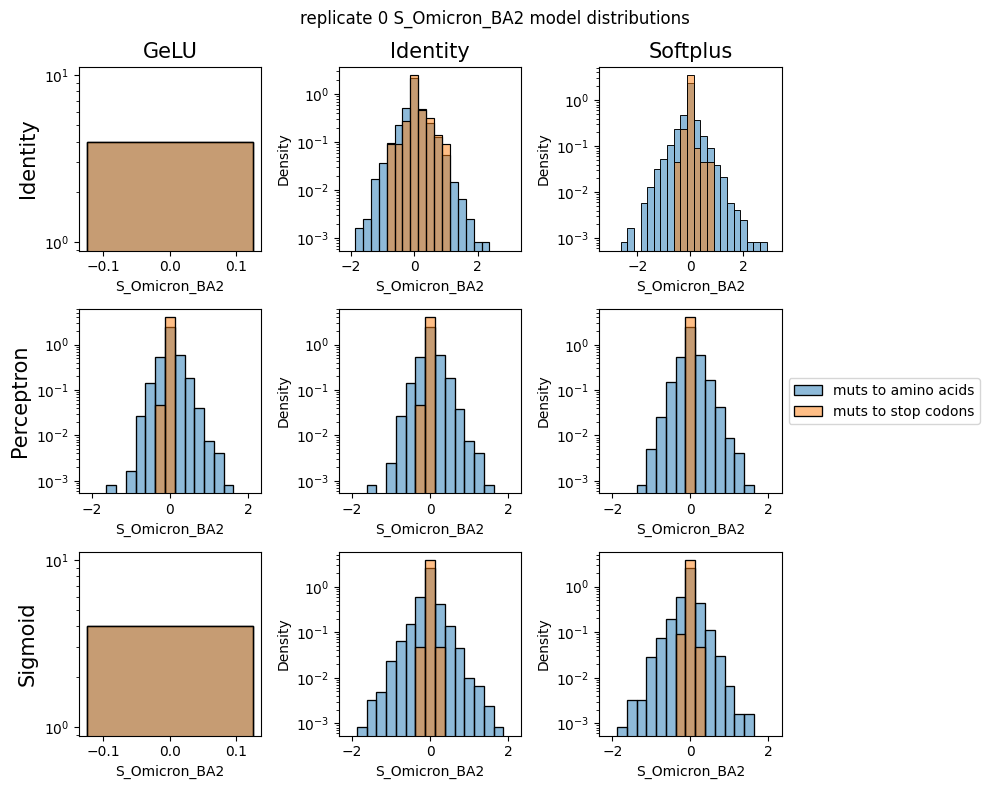

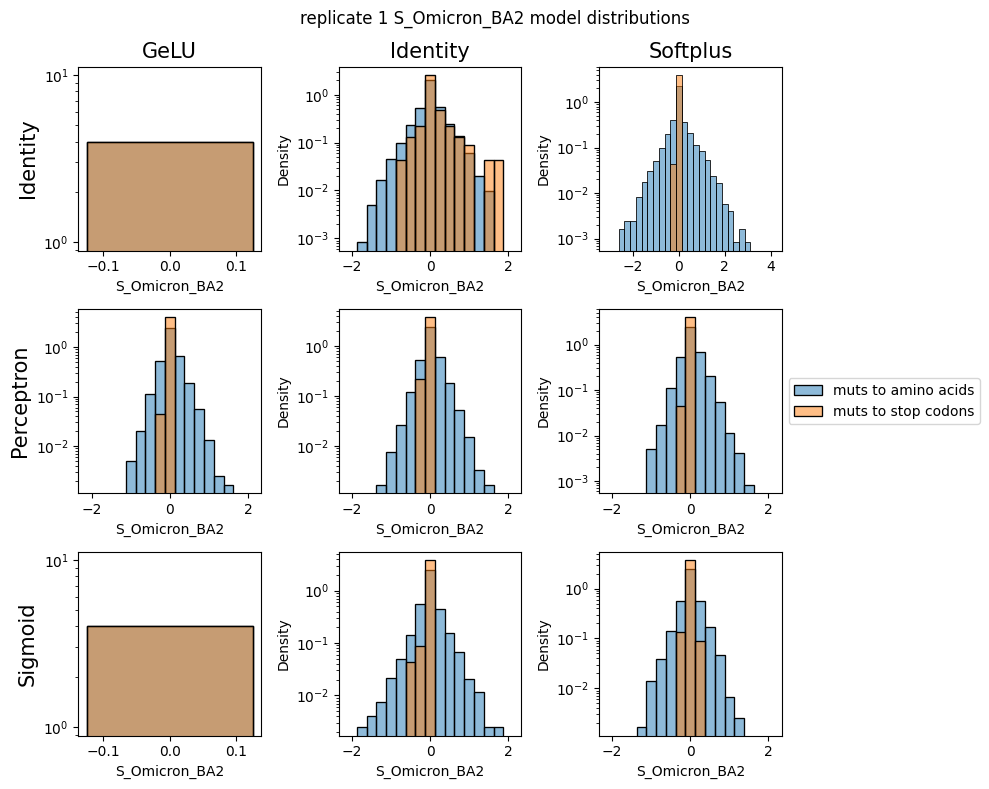

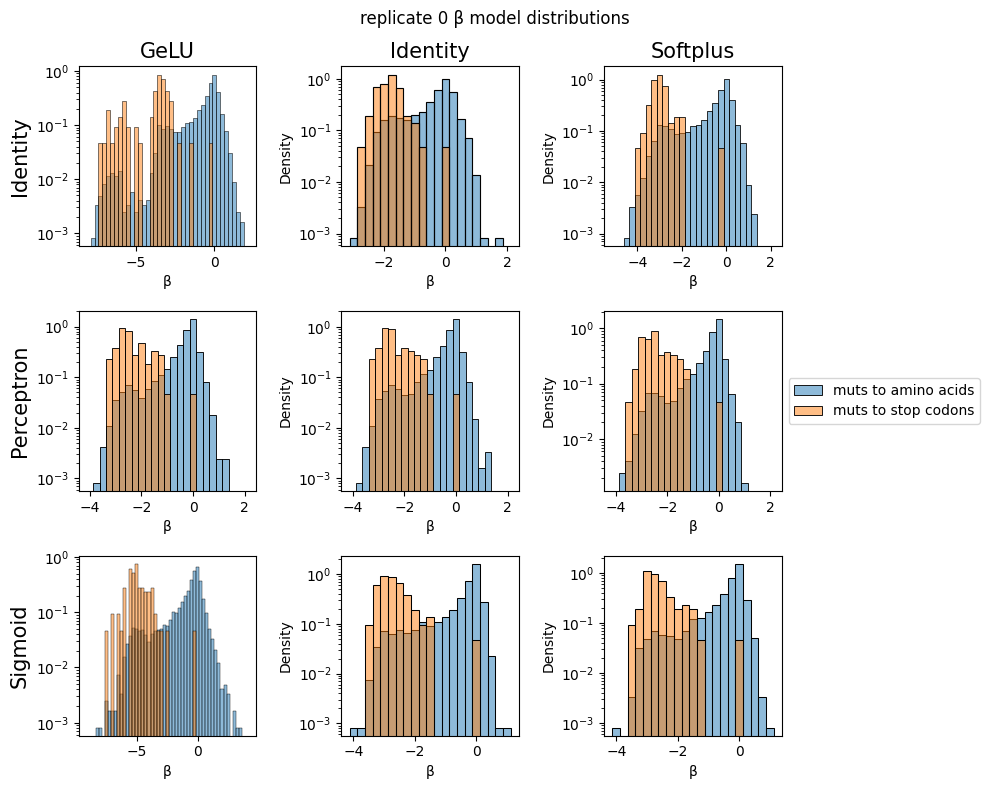

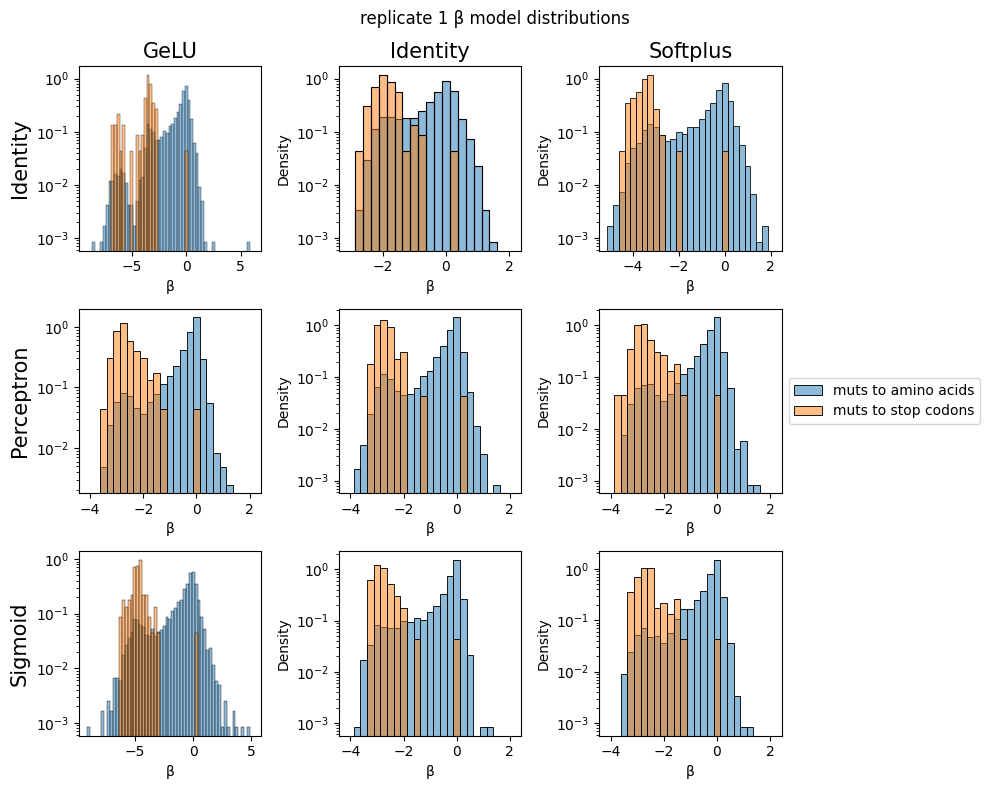

In [83]:
for param in (shift_params + ['β']):
    for rep in [0, 1]:
    
        fig, ax = plt.subplots(3,3,figsize=[10,8], sharex=False, sharey=False)
        for row, (gep, gep_models) in enumerate(
            models.loc[0:17].query("replicate == @rep").groupby('epistatic_model')
        ):
            for col, (out, out_models) in enumerate(gep_models.groupby('output_activation')):
                assert len(out_models) == 1
                for model, model_row in out_models.iterrows():
                    # the failed fits are NaN
                    if type(model_row.model_10000) == multidms.MultiDmsModel:
                        mod = model_row.model_10000
                        mod.plot_param_hist(
                            param, ax=ax[row, col], show=False #, alpha=0.08, legend=False
                        )


                if col == 0: ax[row, col].set_ylabel(gep, size=15)
                if row == 0: ax[row, col].set_title(out, size=15)
                ax[row, col].set_yscale('log')

        ax[1, 2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        fig.suptitle(f"replicate {rep} {param} model distributions")
        plt.tight_layout()
        plt.show()

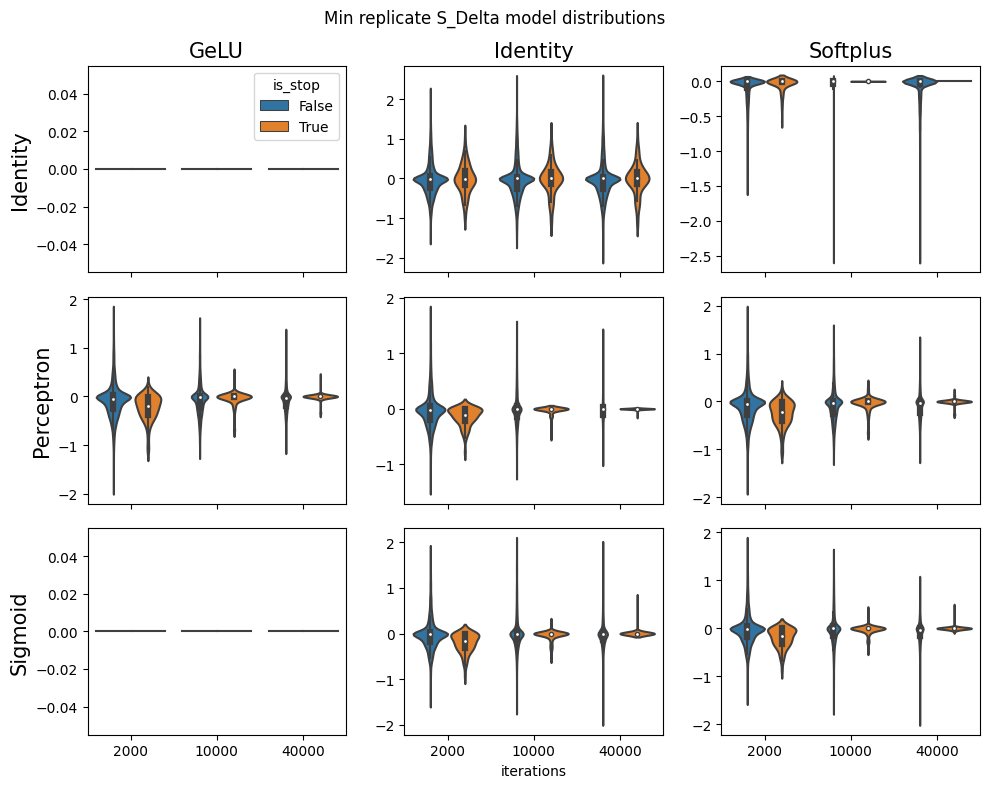

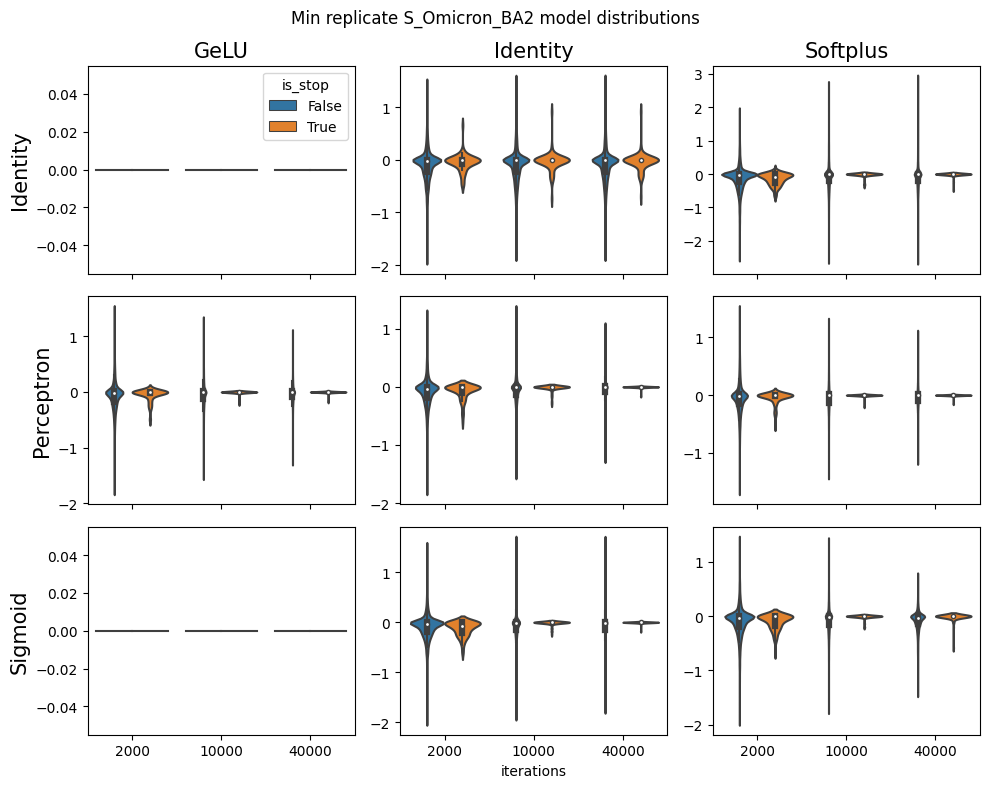

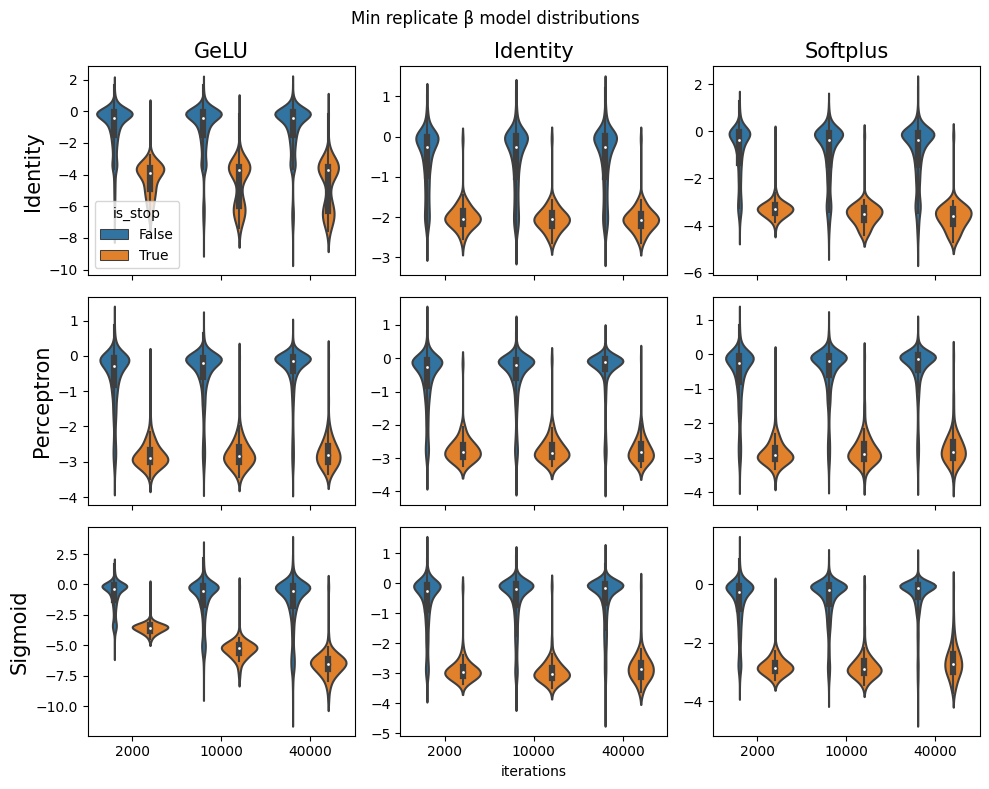

In [151]:
for param in (shift_params + ['β']):
    
    fig, ax = plt.subplots(3,3,figsize=[10,8], sharex=True, sharey=False)
    for row, (gep, gep_models) in enumerate(
        models.loc[0:17].groupby('epistatic_model')
    ):
        for col, (out, out_models) in enumerate(gep_models.groupby('output_activation')):
            assert len(out_models) == 2
            
            stacked = pd.DataFrame()
            for fit_iter in [2000, 10000, 40000]:
                fit_dict = {}
                for i, fit in out_models.iterrows():
                    fit_dict[f"rep_{fit.replicate}"] = fit[f"model_{fit_iter}"]

                rep_comb_mut_df = combine_replicate_muts_min(fit_dict).reset_index()
                rep_comb_mut_df = rep_comb_mut_df.assign(iterations = fit_iter)
                rep_comb_mut_df = rep_comb_mut_df.assign(
                    is_stop = [True if mut == "*" else False for mut in rep_comb_mut_df.muts]
                )
                
                stacked = pd.concat([stacked, rep_comb_mut_df])
            
            
            sns.violinplot(
                stacked, 
                x="iterations", 
                y=f"min_{param}", 
                hue="is_stop", 
                split=False, 
                ax=ax[row, col]
            )
            if not (row == 0 and col==0):
                ax[row, col].legend().set_visible(False)
                
            if not (row == 1 and col==0):
                ax[row, col].set_ylabel("")
                
            if not (row == 2 and col==1):
                ax[row, col].set_xlabel("")
                
            if col == 0: ax[row, col].set_ylabel(gep, size=15)
            if row == 0: ax[row, col].set_title(out, size=15)
    
    fig.suptitle(f"Min replicate {param} model distributions")
    fig.savefig(f"Min-{param}-violin.png")
    
    plt.tight_layout()
    plt.show()

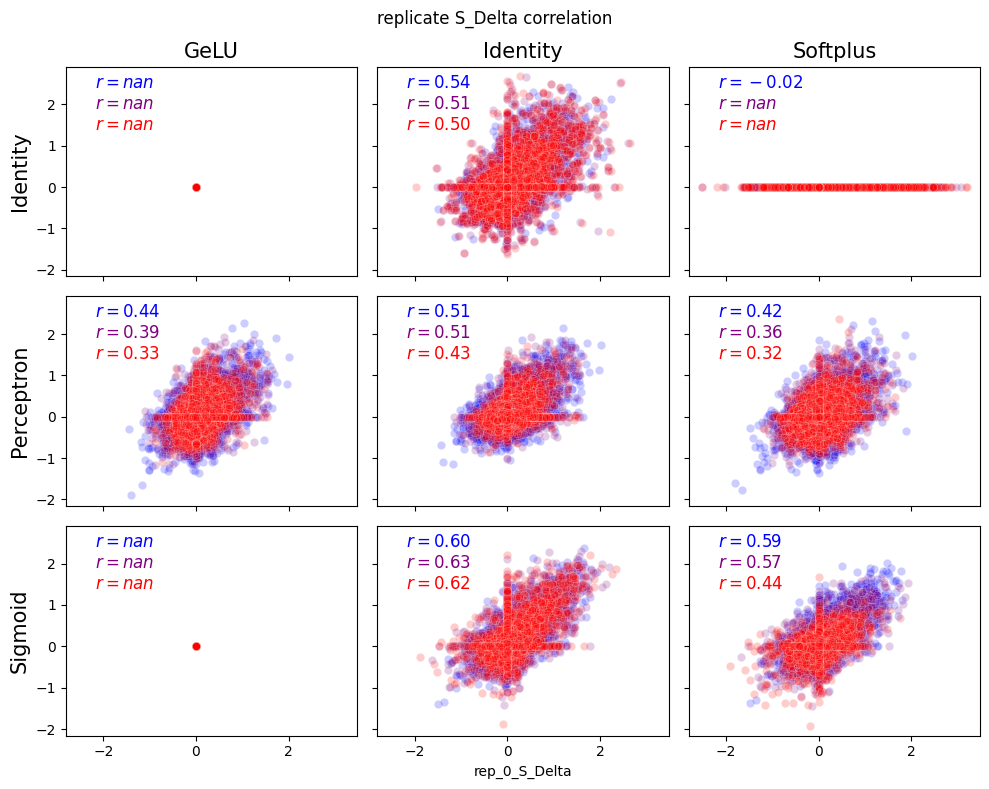

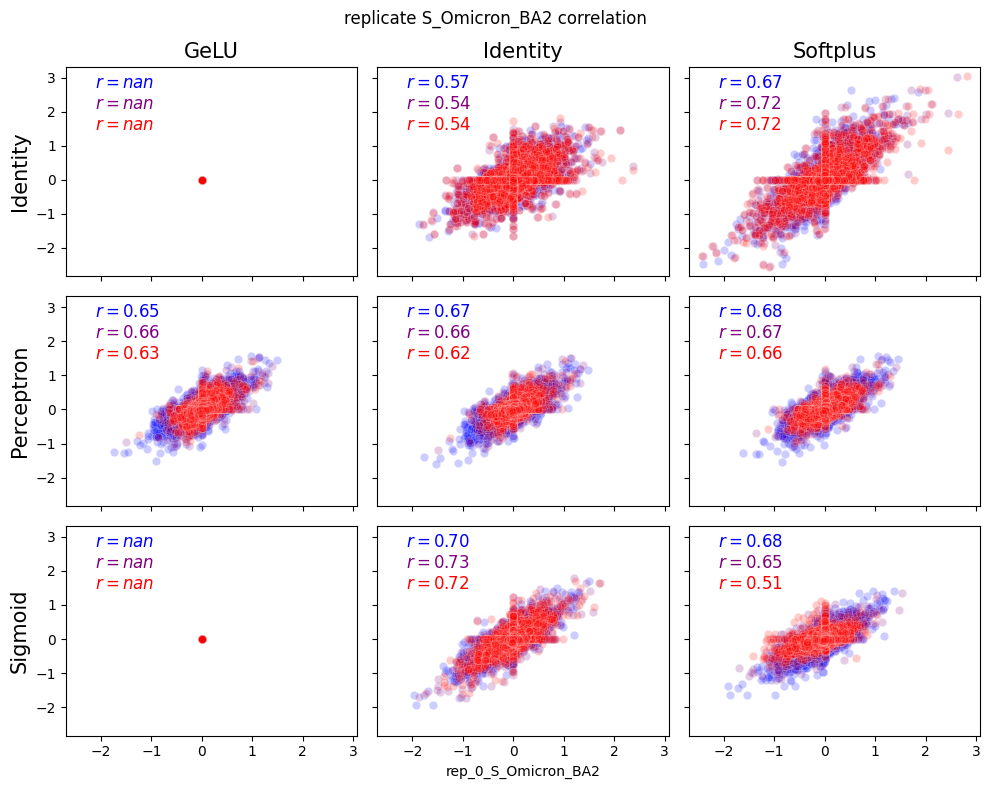

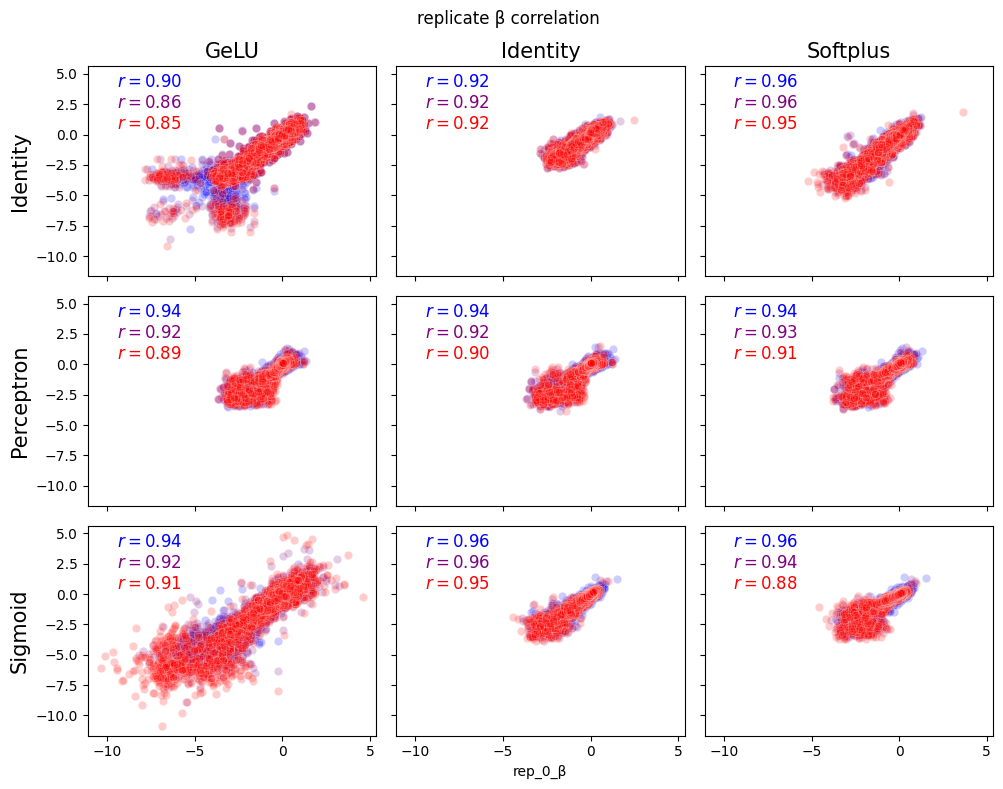

In [102]:
colors = {
    2000:"blue",
    10000:"purple",
    40000:"red"
}
import warnings
warnings.filterwarnings("ignore")
for param in (shift_params + ['β']):
    
    fig, ax = plt.subplots(3,3,figsize=[10,8], sharex=True, sharey=True)
    for row, (gep, gep_models) in enumerate(
        models.loc[0:17].groupby('epistatic_model')
    ):
        for col, (out, out_models) in enumerate(gep_models.groupby('output_activation')):
            assert len(out_models) == 2
            
            for i,fit_iter in enumerate([2000, 10000, 40000]):
                fit_dict = {}
                for j, fit in out_models.iterrows():
                    fit_dict[f"rep_{fit.replicate}"] = fit[f"model_{fit_iter}"]
                rep_comb_mut_df = combine_replicate_muts(fit_dict).reset_index()
                r = pearsonr(
                        rep_comb_mut_df[f"rep_0_{param}"], 
                        rep_comb_mut_df[f"rep_1_{param}"]
                    )[0]

                sns.scatterplot(
                    rep_comb_mut_df, 
                    x=f"rep_0_{param}", 
                    y=f"rep_1_{param}", 
                    ax=ax[row, col],
                    c=colors[fit_iter],
                    alpha=0.2
                )
                ax[row, col].annotate(
                    f"$r = {r:.2f}$", 
                    (0.1, 0.9 - (0.1 * i)), 
                    xycoords="axes fraction", 
                    fontsize=12,
                    color=colors[fit_iter]
                )
            
            
#             if not (row == 0 and col==0):
#                 ax[row, col].legend().set_visible(False)
                
            if not (row == 1 and col==0):
                ax[row, col].set_ylabel("")
                
            if not (row == 2 and col==1):
                ax[row, col].set_xlabel("")
                
            if col == 0: ax[row, col].set_ylabel(gep, size=15)
            if row == 0: ax[row, col].set_title(out, size=15)
    
    fig.suptitle(f"replicate {param} correlation")
    fig.savefig(f"{param}-corr.png")
    
    plt.tight_layout()
    plt.show()

## Lasso Search (Sensitivity)

In [34]:
fit_iter = 0
for lasso in [2e-7, 2e-6, 2e-5, 2e-4, 2e-3]:
    for output in ["Identity", "Softplus"]:

        new = {
            'epistatic_model' : "Sigmoid",
            'output_activation' : output,
            'warmup_beta':True,
            'λ_ridge_beta':0,
            'λ_ridge_shift':0,
            'λ_ridge_gamma':1e-3,
            'λ_lasso_shift':lasso,
            'conditional_c':False,
            'tol':1e-6,
            'save_model_at':[2000, 10000, 40000],
            'num_training_steps': 20,
            'iterations_per_step':2000
        }
        start_t = time.time()
        model = fit_wrapper(datasets.loc[0, "data"], **new)
        model['replicate'] = replicate
        models = pd.concat([models, model])
        end_t = time.time()
        fit_iter += 1
        print(f"Done with {fit_iter}/10! Total time: {round(end_t - start_t)}")
        print("------------------------------------------")

running:
{'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7fcaac96bf70>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': True,
 'init_C_ref': 0.0,
 'iterations_per_step': 2000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 20,
 'output_activation': 'Identity',
 'save_model_at': [2000, 10000, 40000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': True,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-07,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 0}
training_step 0/20, Loss: 0.7311807350856919, Time: 33 Seconds
training_step 1/20, Loss: 0.7026117432107784, Time: 30 Seconds
training_step 2/20, Loss: 0.6921105203742017, Time: 29 Seconds
training_step 3/20, Loss: 0.6858606199138321, Time: 29 Seconds
training_step 4/20, Loss: 0.6814677212690329, Time: 29 Seconds
training_step 5/20, Loss: 0.6781795965351374, Time: 29 Seconds
t

training_step 0/20, Loss: 0.7570938330141537, Time: 33 Seconds
training_step 1/20, Loss: 0.7315446334519122, Time: 30 Seconds
training_step 2/20, Loss: 0.7190136072414409, Time: 30 Seconds
training_step 3/20, Loss: 0.7145736124269984, Time: 29 Seconds
training_step 4/20, Loss: 0.7115503496048874, Time: 29 Seconds
training_step 5/20, Loss: 0.7098212542610465, Time: 29 Seconds
training_step 6/20, Loss: 0.7085880169192407, Time: 29 Seconds
training_step 7/20, Loss: 0.7076272201428545, Time: 29 Seconds
training_step 8/20, Loss: 0.7068629804807036, Time: 29 Seconds
training_step 9/20, Loss: 0.7062469477003055, Time: 29 Seconds
training_step 10/20, Loss: 0.7057369340889686, Time: 29 Seconds
training_step 11/20, Loss: 0.7052754734189914, Time: 29 Seconds
training_step 12/20, Loss: 0.7048324035410839, Time: 29 Seconds
training_step 13/20, Loss: 0.7044695320046468, Time: 29 Seconds
training_step 14/20, Loss: 0.7041433693515158, Time: 29 Seconds
training_step 15/20, Loss: 0.7038054833788534, Tim

training_step 6/20, Loss: 0.8950353924955905, Time: 29 Seconds
training_step 7/20, Loss: 0.8945741073660662, Time: 29 Seconds
training_step 8/20, Loss: 0.8942148795790759, Time: 29 Seconds
training_step 9/20, Loss: 0.8939236368122869, Time: 29 Seconds
training_step 10/20, Loss: 0.8936839337354316, Time: 29 Seconds
training_step 11/20, Loss: 0.8934793334611321, Time: 29 Seconds
training_step 12/20, Loss: 0.8932983284897563, Time: 29 Seconds
training_step 13/20, Loss: 0.893124456808424, Time: 29 Seconds
training_step 14/20, Loss: 0.8929468235001646, Time: 29 Seconds
training_step 15/20, Loss: 0.8927709343279497, Time: 29 Seconds
training_step 16/20, Loss: 0.8926250471993149, Time: 36 Seconds
training_step 17/20, Loss: 0.8924837734536913, Time: 31 Seconds
training_step 18/20, Loss: 0.8923467291005955, Time: 31 Seconds
training_step 19/20, Loss: 0.8922417620075869, Time: 30 Seconds
Done with 9/10! Total time: 595
------------------------------------------
running:
{'conditional_c': False,


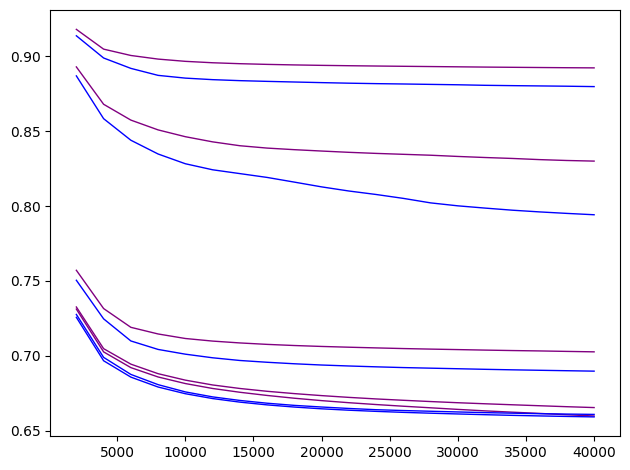

In [107]:
ls_models = models.loc[18:27]
fig, ax = plt.subplots()
for model, model_row in ls_models.iterrows():
    ax.plot(
        [2000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        lw=1,
        color = output_color_dict[model_row.output_activation],
        linestyle= replicate_style_dict[model_row.replicate],
        label=f"{model_row.output_activation} rep: {model_row.replicate}"
    )

plt.tight_layout()
plt.show()

wts  sites muts  lasso_2e-07_β  lasso_2e-06_β  lasso_2e-05_β  \
mutation                                                                
M1I        M      1    I      -3.137380      -3.068631      -2.855123   
F2L        F      2    L       0.313202       0.271246       0.134923   
V3A        V      3    A       0.023513       0.025561       0.008812   
V3F        V      3    F      -0.397179      -0.348946      -0.206223   
V3G        V      3    G      -0.008099      -0.006865      -0.000751   
...       ..    ...  ...            ...            ...            ...   
S1252T     S   1252    T      -0.174571      -0.160921      -0.110123   
S1252V     S   1252    V       0.281676       0.233689       0.105934   
S1252W     S   1252    W       0.024442       0.044978       0.074360   
S1252Y     S   1252    Y       0.576643       0.489956       0.245662   
S1252*     S   1252    *      -0.165800      -0.153287      -0.086568   

          lasso_0.0002_β  lasso_0.002_β     avg_β  lasso_2e-07_S_Delta  ...  \
mutation                                                                ...   
M1I            -3.511693      -4.490755 -3.412716            -0.587653  ...   
F2L             0.046867       0.076543  0.168556            -0.122984  ...   
V3A            -0.063149      -0.126961 -0.026445            -0.869748  ...   
V3F            -0.202586      -0.324640 -0.295915             0.004545  ...   
V3G             0.002865       0.003873 -0.001796            -0.214577  ...   
...                  ...            ...       ...                  ...  ...   
S1252T         -0.143582      -0.262627 -0.170365            -0.229709  ...   
S1252V          0.084605       0.152588  0.171698            -0.418669  ...   
S1252W          0.117754       0.173336  0.086974             0.521047  ...   
S1252Y          0.232351       0.443159  0.397554            -0.119824  ...   
S1252*         -0.067406      -0.105538 -0.115720            -0.053799  ...   

          lasso_2e-05_S_Delta  lasso_0.0002_S_Delta  lasso_0.002_S_Delta  \
mutation                                                                   
M1I                 -0.000000             -0.000000                 -0.0   
F2L                 -0.062289              0.000000                  0.0   
V3A                 -0.447921             -0.000000                 -0.0   
V3F                 -0.000000              0.000000                  0.0   
V3G                 -0.106314             -0.000000                 -0.0   
...                       ...                   ...                  ...   
S1252T              -0.136659             -0.077916                 -0.0   
S1252V              -0.120084             -0.000000                 -0.0   
S1252W               0.244272              0.000000                  0.0   
S1252Y              -0.000000             -0.000000                 -0.0   
S1252*               0.000000             -0.000000                 -0.0   

          avg_S_Delta  lasso_2e-07_S_Omicron_BA2  lasso_2e-06_S_Omicron_BA2  \
mutation                                                                      
M1I         -0.188375                  -0.404830                  -0.117925   
F2L         -0.059764                  -0.480740                  -0.407637   
V3A         -0.418174                  -0.170624                  -0.138984   
V3F         -0.000613                   0.006273                  -0.000648   
V3G         -0.101199                   0.033986                   0.031370   
...               ...                        ...                        ...   
S1252T      -0.128979                  -0.148695                  -0.126853   
S1252V      -0.175458                  -0.138908                  -0.108989   
S1252W       0.243172                   0.160053                   0.115297   
S1252Y      -0.041295                  -0.094040                  -0.071218   
S1252*      -0.016375                   0.242510                   0.227666   

          lass

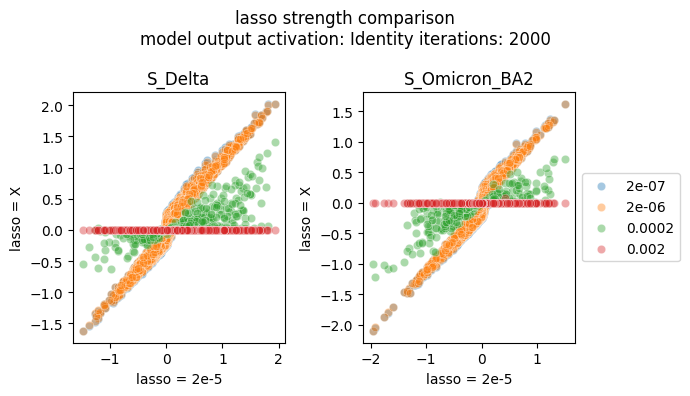

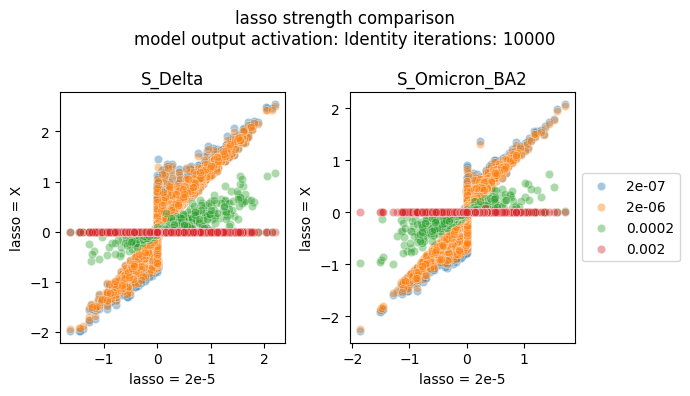

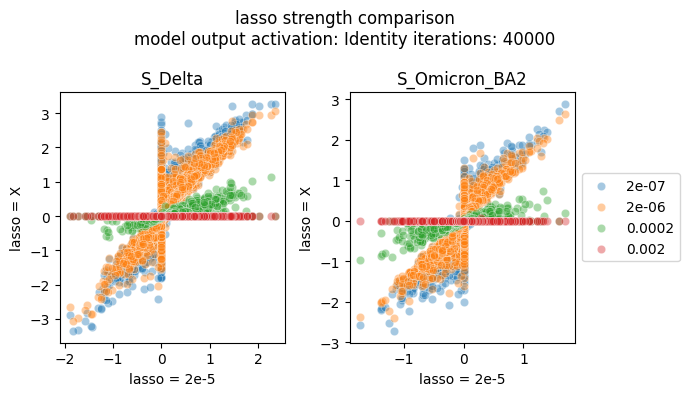

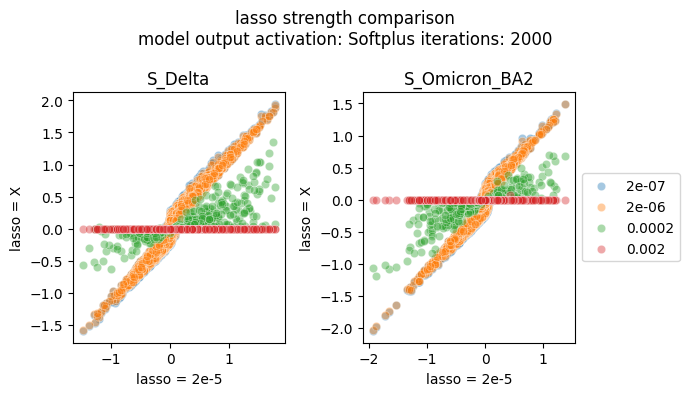

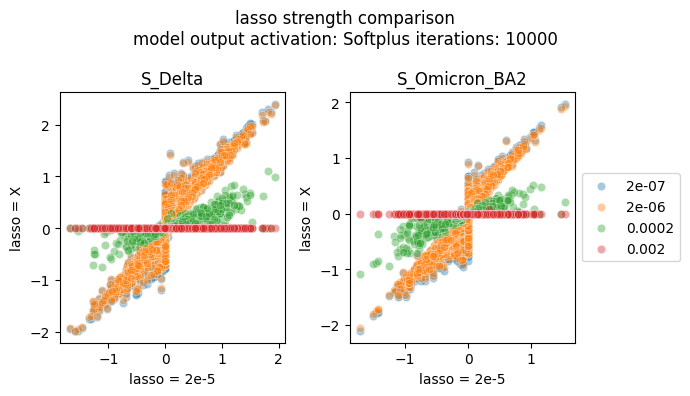

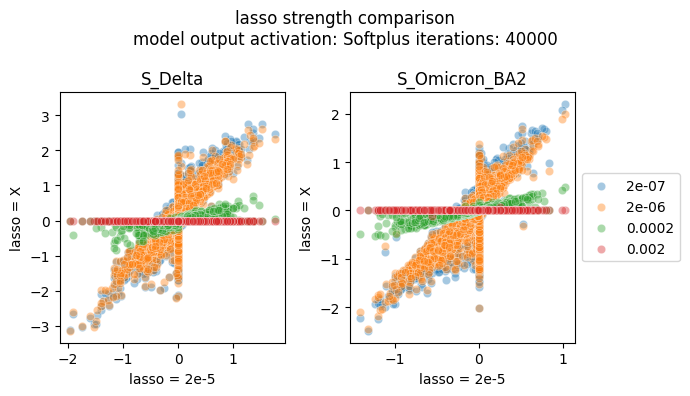

In [139]:
for oa in ["Identity", "Softplus"]:
    for iterations in [2000, 10000, 40000]:

        fit_dict = {
            f"lasso_{row.λ_lasso_shift}":row[f"model_{iterations}"] 
            for idx, row in ls_models.iterrows()
            if row.output_activation == oa
        }
        comb_mut_df = combine_replicate_muts(fit_dict)
        comb_mut_df
        fig, ax = plt.subplots(1,2, figsize=[7,4])
        for i, param in enumerate(shift_params):
            lasso_compare = [
                col for col in comb_mut_df.columns 
                if col.endswith(param) and not col.startswith("lasso_2e-05") and not col.startswith("avg")
            ]

            for lc in lasso_compare:
                sns.scatterplot(
                    comb_mut_df, 
                    x=f"lasso_2e-05_{param}", 
                    y=lc, 
                    ax=ax[i],
                    label=lc.split("_")[1],
                    alpha=0.4
                )
            ax[i].set_ylabel("lasso = X")
            ax[i].set_xlabel("lasso = 2e-5")
            ax[i].set_title(param)
        ax[0].legend().set_visible(False)
        ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
        fig.suptitle(f"lasso strength comparison\nmodel output activation: {oa} iterations: {iterations}")
        plt.tight_layout()
        fig.savefig(f"lasso-compare-{oa}-{iterations}.png")
        plt.show()

## Seed replicates

In [41]:
fit_iter = 0
for output in ["Identity", "Softplus"]:
    for seed in [34, 636, 134, 921, 2]:
#         for replicate in datasets.index.values:

        new = {
            'epistatic_model' : "Sigmoid",
            'output_activation' : output,
            'warmup_beta':True,
            'λ_ridge_beta':0,
            'λ_ridge_shift':0,
            'λ_ridge_gamma':1e-3,
            'λ_lasso_shift':2e-5,
            'conditional_c':False,
            'tol':1e-6,
            'save_model_at':[2000, 10000, 40000],
            'num_training_steps': 20,
            'iterations_per_step':2000,
            'PRNGKey':seed
        }
        start_t = time.time()
        model = fit_wrapper(datasets.loc[replicate, "data"], **new)
        model['replicate'] = replicate
        models = pd.concat([models, model])
        end_t = time.time()
        fit_iter += 1
        print(f"Done with {fit_iter}/10! Total time: {round(end_t - start_t)}")
        print("------------------------------------------")

running:
{'PRNGKey': 34,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7fcaac96b070>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': True,
 'init_C_ref': 0.0,
 'iterations_per_step': 2000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 20,
 'output_activation': 'Identity',
 'save_model_at': [2000, 10000, 40000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': True,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 0}
training_step 0/20, Loss: 0.7046216990701251, Time: 31 Seconds
training_step 1/20, Loss: 0.6668527760594005, Time: 29 Seconds
training_step 2/20, Loss: 0.6563419165370671, Time: 28 Seconds
training_step 3/20, Loss: 0.6506146166839395, Time: 28 Seconds
training_step 4/20, Loss: 0.6471931104637543, Time: 29 Seconds
training_step 5/20, Loss: 0.6447895769854091, Ti

training_step 0/20, Loss: 0.7043165862470067, Time: 31 Seconds
training_step 1/20, Loss: 0.6673983176554575, Time: 28 Seconds
training_step 2/20, Loss: 0.6567521350748875, Time: 28 Seconds
training_step 3/20, Loss: 0.6510178549196488, Time: 28 Seconds
training_step 4/20, Loss: 0.647537140381075, Time: 28 Seconds
training_step 5/20, Loss: 0.6451008077254179, Time: 28 Seconds
training_step 6/20, Loss: 0.64350550676944, Time: 28 Seconds
training_step 7/20, Loss: 0.6423701957462375, Time: 28 Seconds
training_step 8/20, Loss: 0.6414744859579935, Time: 28 Seconds
training_step 9/20, Loss: 0.6407099760419273, Time: 28 Seconds
training_step 10/20, Loss: 0.640016208383776, Time: 28 Seconds
training_step 11/20, Loss: 0.6393884326501862, Time: 28 Seconds
training_step 12/20, Loss: 0.6386820596497705, Time: 28 Seconds
training_step 13/20, Loss: 0.6375990394669215, Time: 36 Seconds
training_step 14/20, Loss: 0.6370112117552182, Time: 31 Seconds
training_step 15/20, Loss: 0.6365606130174051, Time: 3

training_step 5/20, Loss: 0.629936328641222, Time: 29 Seconds
training_step 6/20, Loss: 0.6278612232569507, Time: 29 Seconds
training_step 7/20, Loss: 0.6261682257758975, Time: 29 Seconds
training_step 8/20, Loss: 0.6247193457829824, Time: 29 Seconds
training_step 9/20, Loss: 0.6234306368651813, Time: 29 Seconds
training_step 10/20, Loss: 0.6220244723262358, Time: 29 Seconds
training_step 11/20, Loss: 0.6204250985625418, Time: 29 Seconds
training_step 12/20, Loss: 0.6188498528673061, Time: 29 Seconds
training_step 13/20, Loss: 0.6178612785189614, Time: 29 Seconds
training_step 14/20, Loss: 0.6169976851569667, Time: 29 Seconds
training_step 15/20, Loss: 0.6160580280626726, Time: 29 Seconds
training_step 16/20, Loss: 0.6154356740770743, Time: 29 Seconds
training_step 17/20, Loss: 0.615044230129614, Time: 29 Seconds
training_step 18/20, Loss: 0.6147250587590675, Time: 29 Seconds
training_step 19/20, Loss: 0.6144088914022899, Time: 29 Seconds
Done with 9/10! Total time: 584
---------------

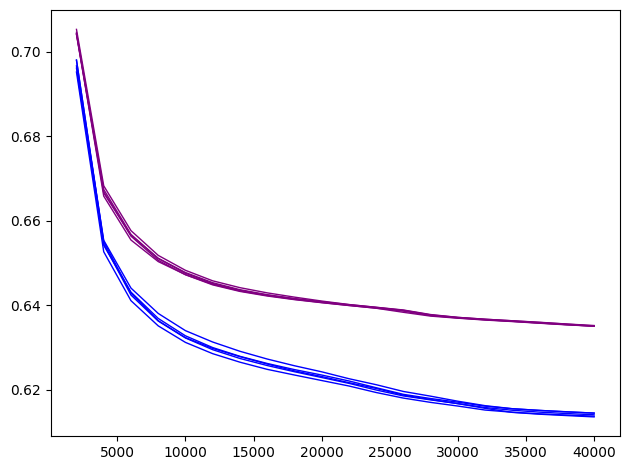

In [128]:
seed_models = models.loc[28:]
fig, ax = plt.subplots()
for model, model_row in seed_models.iterrows():
    ax.plot(
        [2000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        lw=1,
        color = output_color_dict[model_row.output_activation],
        linestyle= replicate_style_dict[model_row.replicate],
        label=f"{model_row.output_activation} rep: {model_row.replicate}"
    )

plt.tight_layout()
plt.show()

In [129]:
seed_models.columns

Index(['dataset', 'δ_huber', 'λ_lasso_shift', 'λ_ridge_beta', 'λ_ridge_shift',
       'λ_ridge_gamma', 'data_idx', 'epistatic_model', 'output_activation',
       'lock_beta', 'lock_C_ref', 'gamma_corrected', 'conditional_c',
       'init_C_ref', 'warmup_beta', 'tol', 'num_training_steps',
       'iterations_per_step', 'save_model_at', 'step_loss', 'model_2000',
       'model_10000', 'model_40000', 'replicate', 'PRNGKey'],
      dtype='object')

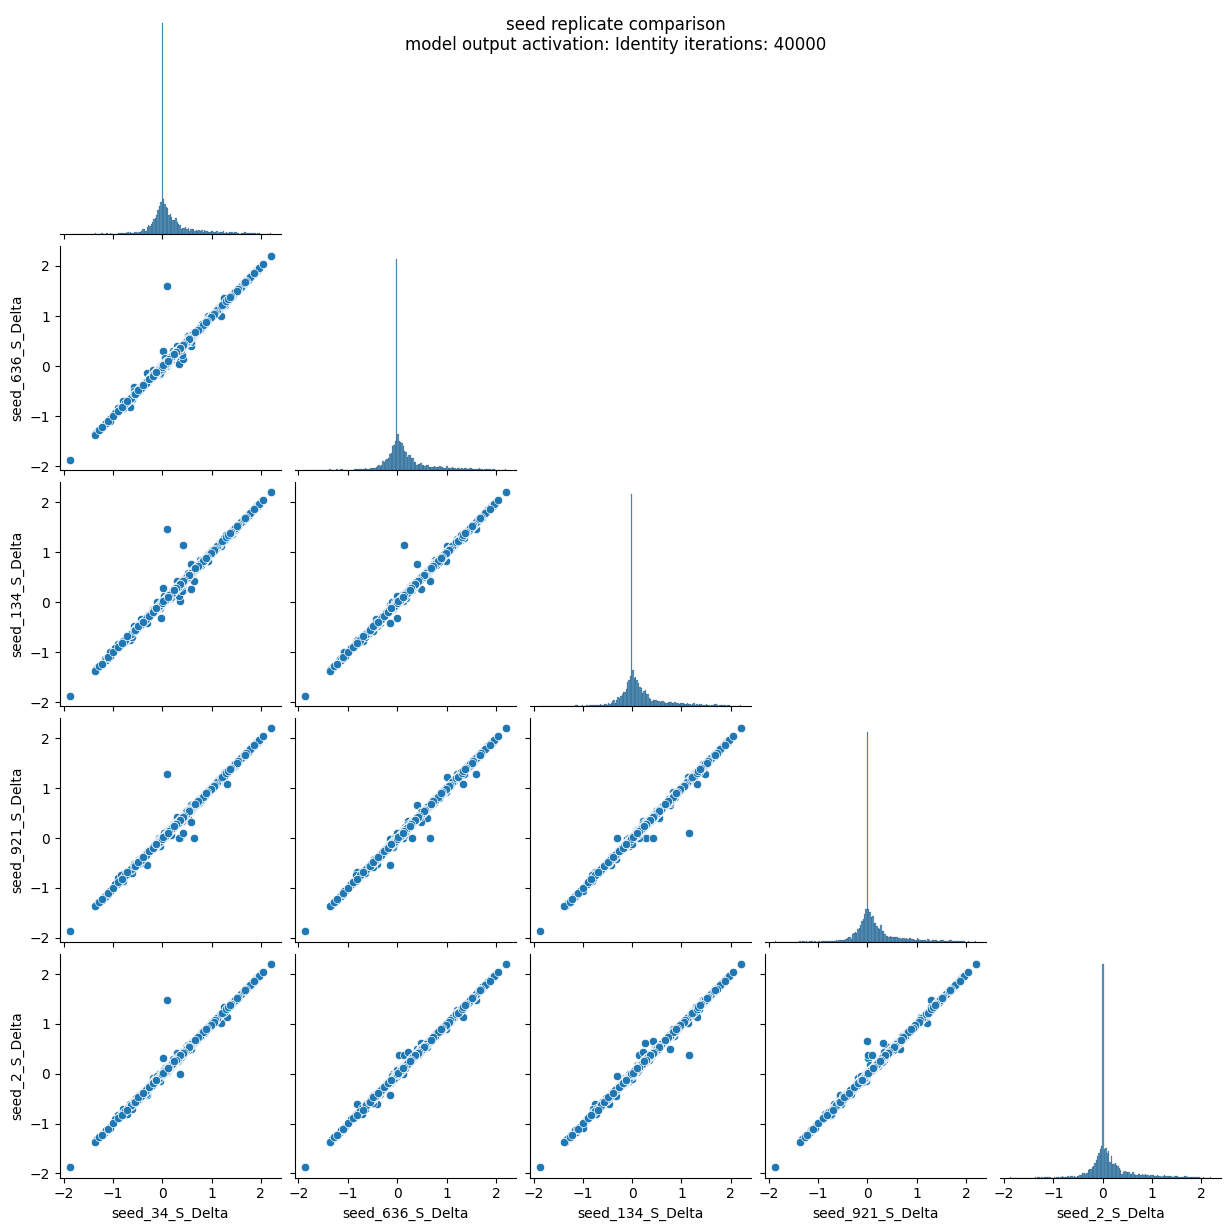

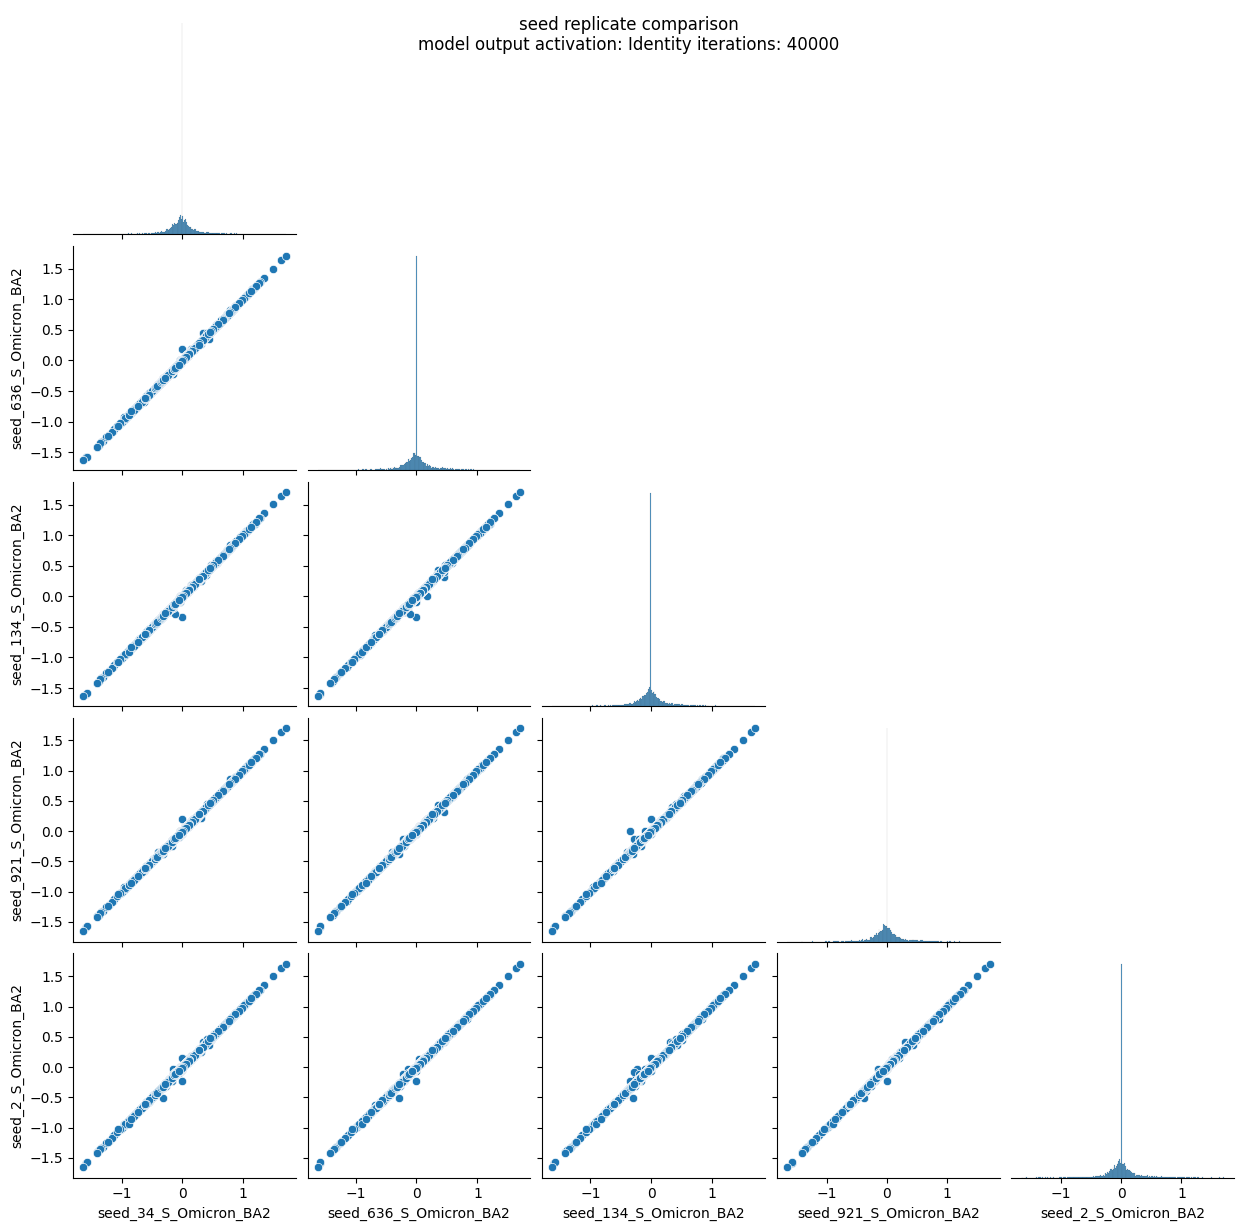

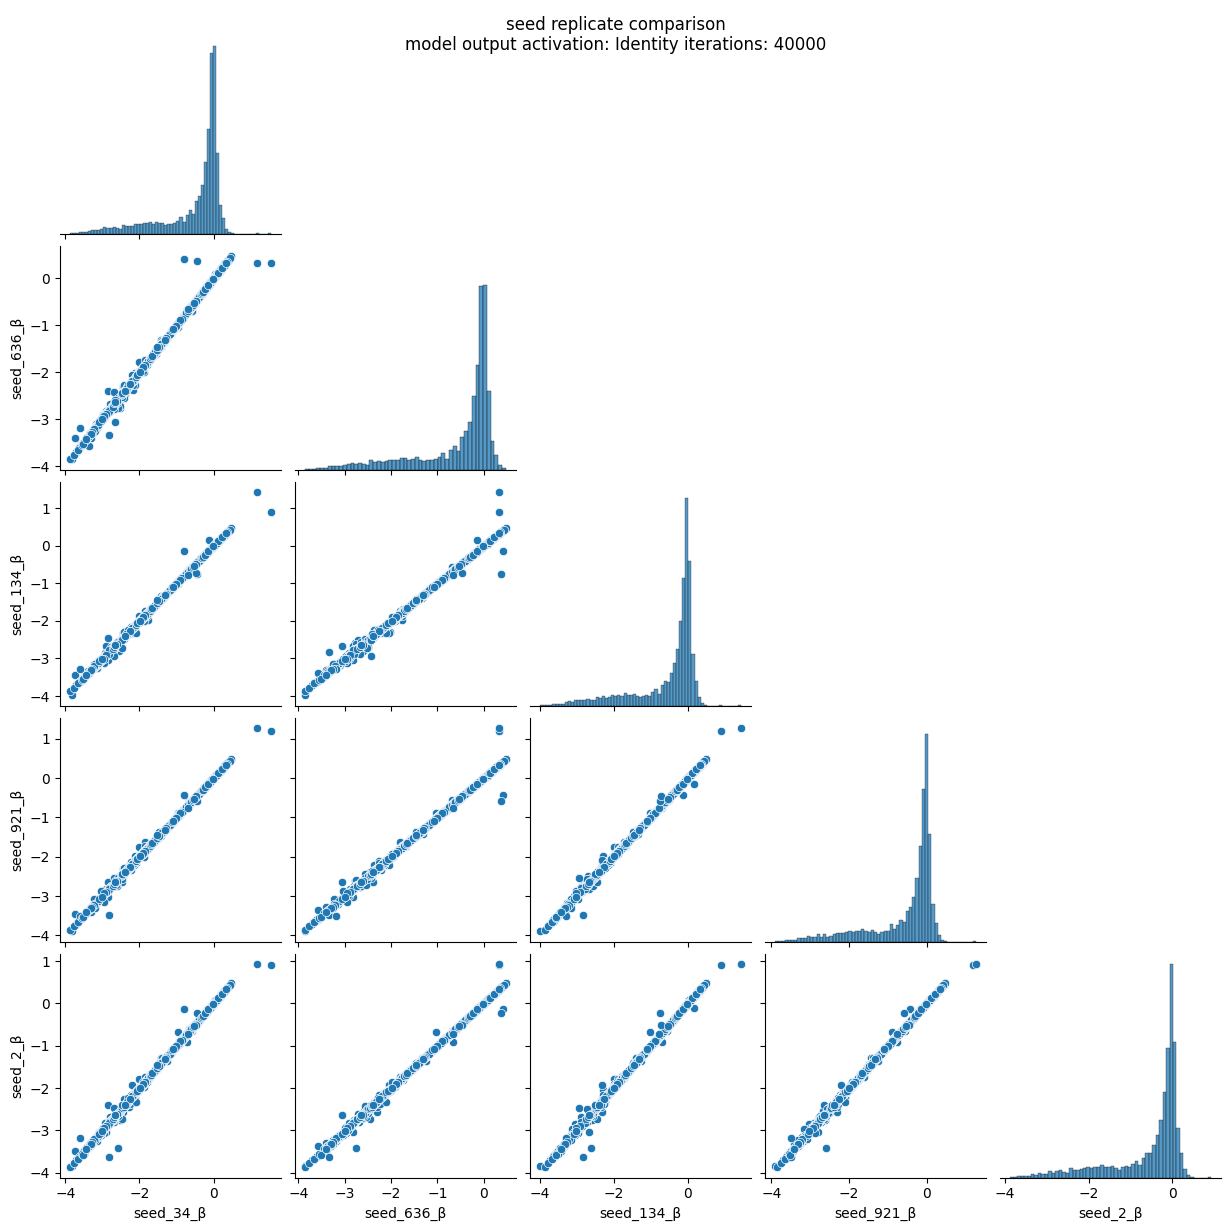

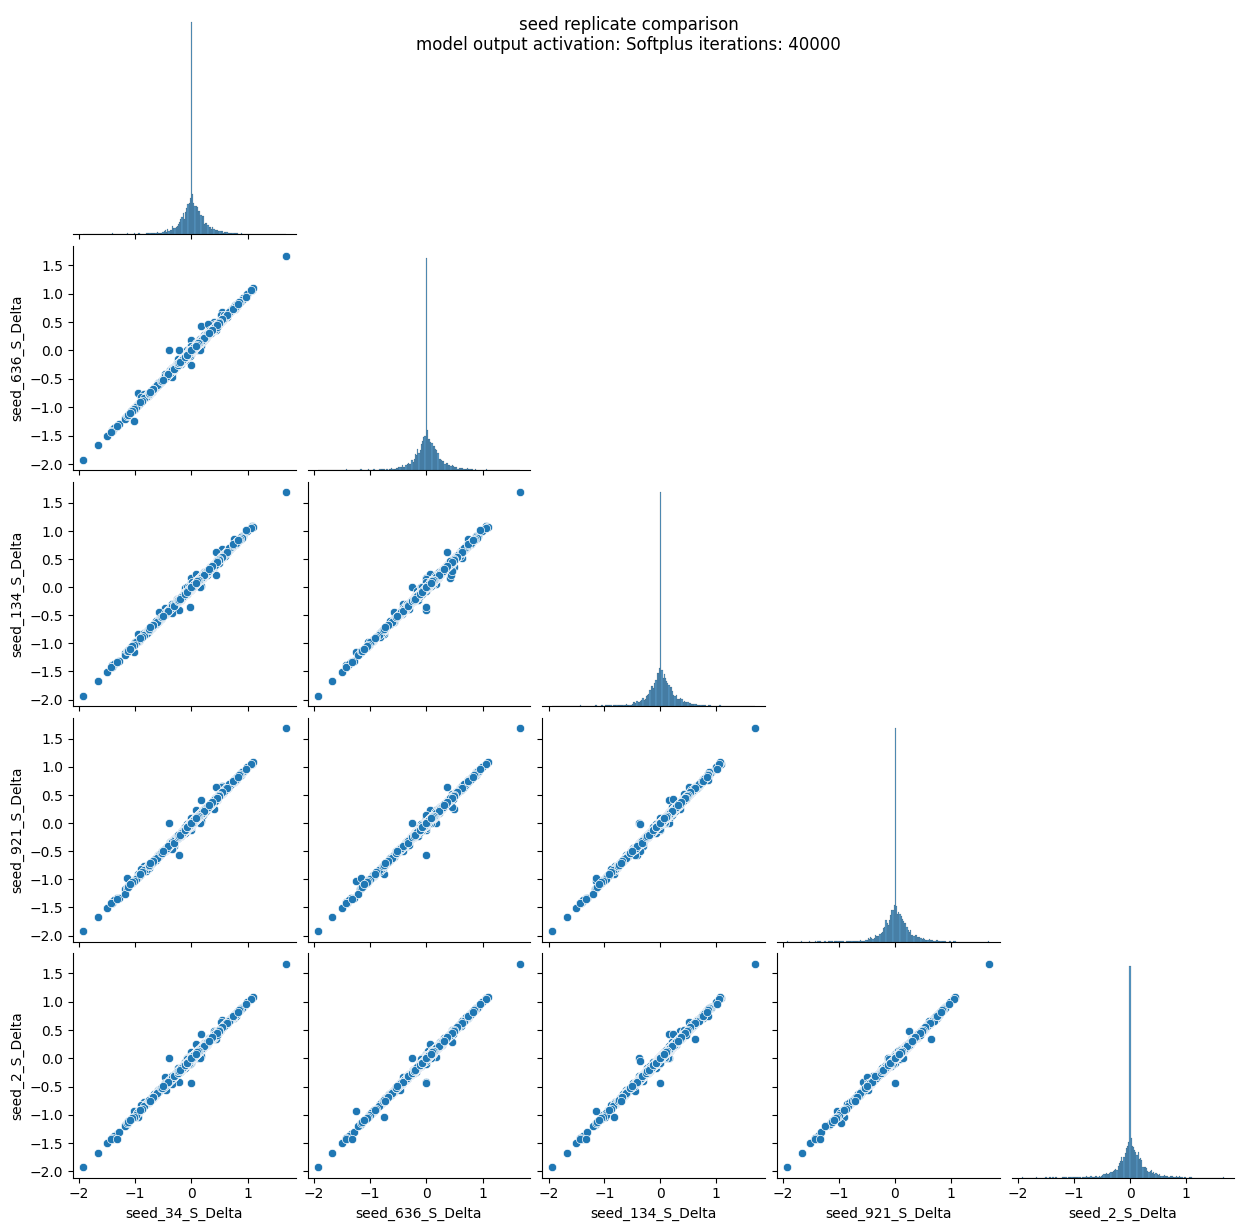

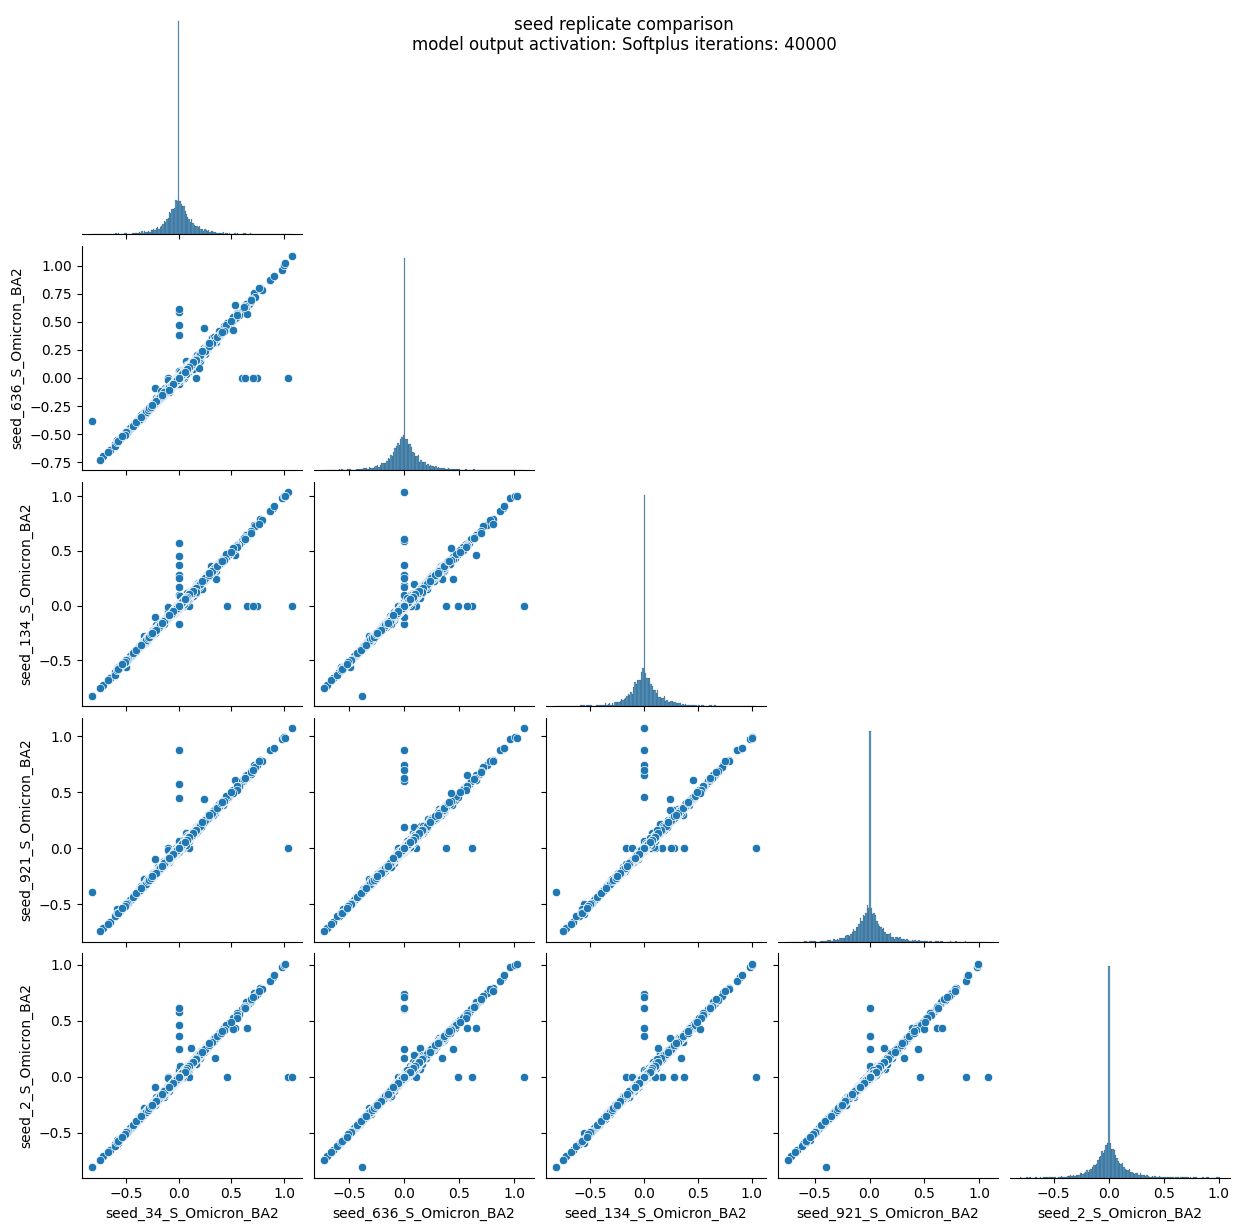

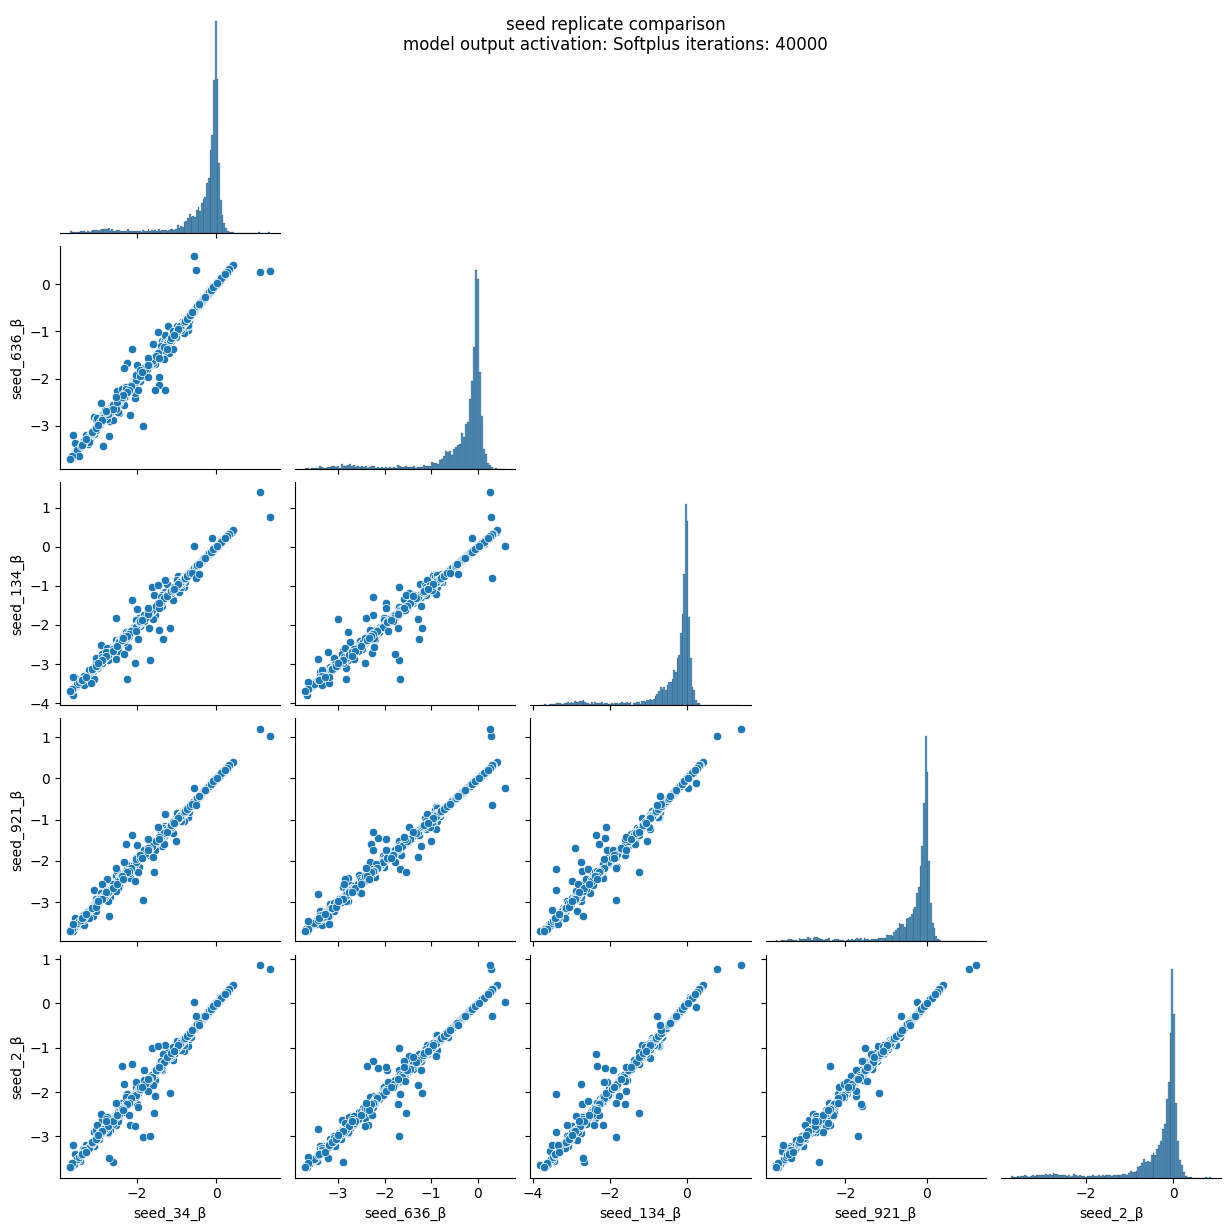

In [147]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
for oa in ["Identity", "Softplus"]:
#     for iterations in [2000, 10000, 40000]:
    for iterations in [40000]:
        

        fit_dict = {
            f"seed_{row.PRNGKey}":row[f"model_{iterations}"] 
            for idx, row in seed_models.iterrows()
            if row.output_activation == oa
        }
        comb_mut_df = combine_replicate_muts(fit_dict)

#         fig, ax = plt.subplots(1,2, figsize=[7,4])
        for i, param in enumerate(shift_params + ['β']):
            seed_compare = [
                col for col in comb_mut_df.columns 
                if col.endswith(param) and not col.startswith("avg")
            ]

#             for lc in lasso_compare:
            g = sns.pairplot(
                comb_mut_df, 
                vars=seed_compare,
                corner=True
            )
#             g.save()
            g.fig.suptitle(f"seed replicate comparison\nmodel output activation: {oa} iterations: {iterations}")
#             plt.tight_layout()
            g.savefig(f"seed-pairplot-{oa}-{param}-{iterations}.png")
            
#             break
#         break
#     break

#             ax[i].set_ylabel("lasso = X")
#             ax[i].set_xlabel("lasso = 2e-5")
#             ax[i].set_title(param)
#         ax[0].legend().set_visible(False)
#         ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
#         fig.suptitle(f"lasso strength comparison\nmodel output activation: {oa} iterations: {iterations}")
#         plt.tight_layout()
#         fig.savefig(f"{oa}-{iterations}.png")
#             plt.show()

In [157]:
replicate

1

In [158]:
for output_activation in ['Softplus', 'Identity']:
    new = {
        'epistatic_model' : "Sigmoid",
        'output_activation' : output_activation,
        'warmup_beta':True,
        'λ_ridge_beta':0,
        'λ_ridge_shift':0,
        'λ_ridge_gamma':1e-3,
        'tol':1e-6,
        'save_model_at':[2000, 10000, 40000, 100000],
        'num_training_steps': 50,
        'iterations_per_step':2000
    }
    start_t = time.time()
    model = fit_wrapper(datasets.loc[0, "data"], **new)
    model['replicate'] = replicate
    models = pd.concat([models, model])
    end_t = time.time()
    print(f"Done with {fit_iter}/18! Total time: {round(end_t - start_t)}")
    print("------------------------------------------")

running:
{'PRNGKey': 0,
 'conditional_c': False,
 'data_idx': 0,
 'dataset': <multidms.data.MultiDmsData object at 0x7fcaac96bf70>,
 'epistatic_model': 'Sigmoid',
 'gamma_corrected': True,
 'init_C_ref': 0.0,
 'iterations_per_step': 2000,
 'lock_C_ref': False,
 'lock_beta': False,
 'num_training_steps': 50,
 'output_activation': 'Softplus',
 'save_model_at': [2000, 10000, 40000, 100000],
 'step_loss': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'tol': 1e-06,
 'warmup_beta': True,
 'δ_huber': 1,
 'λ_lasso_shift': 2e-05,
 'λ_ridge_beta': 0,
 'λ_ridge_gamma': 0.001,
 'λ_ridge_shift': 0}
training_step 0/50, Loss: 0.7509571224435824, Time: 32 Seconds
training_step 1/50, Loss: 0.7248121277209371, Time: 29 Seconds
training_step 2/50, Loss: 0.7099027849941016, Time: 29 Seconds
training_step 3/50, Loss: 0.704265466950

In [160]:
models

dataset δ_huber λ_lasso_shift  \
0   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
1   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
2   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
3   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
4   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
5   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
6   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
7   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
8   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
9   <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
10  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
11  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
12  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
13  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
14  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
15  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
16  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
17  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
18  <multidms.data.MultiDmsData object at 0x7fcaac...       1           0.0   
19  <multidms.data.MultiDmsData object at 0x7fcaac...       1           0.0   
20  <multidms.data.MultiDmsData object at 0x7fcaac...       1      0.000002   
21  <multidms.data.MultiDmsData object at 0x7fcaac...       1      0.000002   
22  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
23  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
24  <multidms.data.MultiDmsData object at 0x7fcaac...       1        0.0002   
25  <multidms.data.MultiDmsData object at 0x7fcaac...       1        0.0002   
26  <multidms.data.MultiDmsData object at 0x7fcaac...       1         0.002   
27  <multidms.data.MultiDmsData object at 0x7fcaac...       1         0.002   
28  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
29  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
30  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
31  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
32  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
33  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
34  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
35  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
36  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
37  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
38  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
39  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
40  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   
41  <multidms.data.MultiDmsData object at 0x7fcaac...       1       0.00002   

   λ_ridge_beta λ_ridge_shift λ_ridge_gamma data_idx epistatic_model  \
0             0             0         0.001        0        Identity   
1             0             0         0.001        0        Identity   
2             0             0         0.001        0        Identity   
3             0             0         0.001        0        Identity   
4             0             0         0.001        0        Identity   
5             0             0         0.001        0        Identity   
6             0             0         0.001        0         Sigmoid   
7             0             0         0.001        0         Sigmoid   


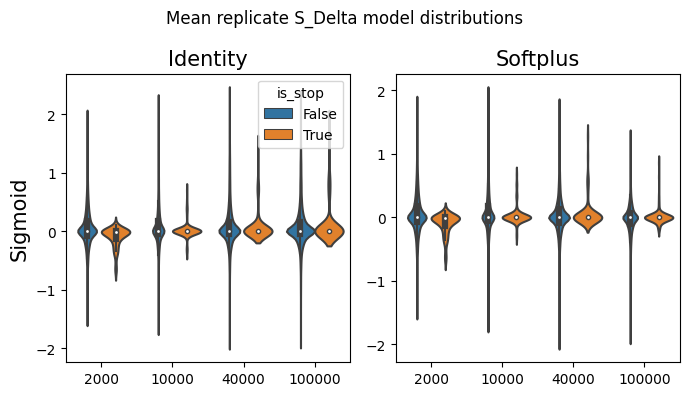

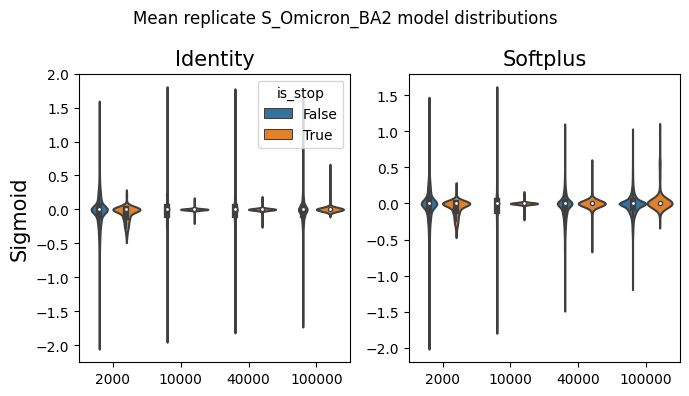

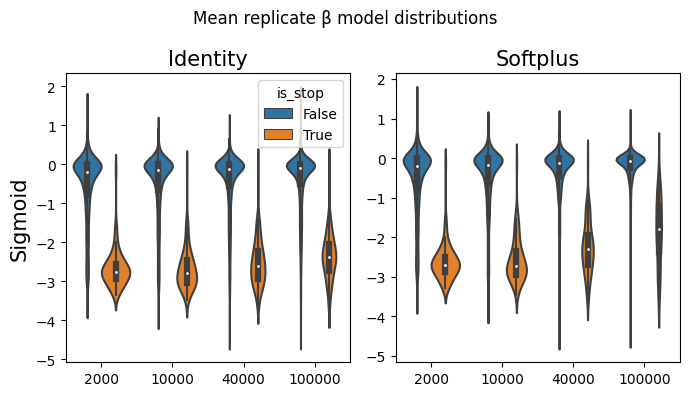

In [171]:
for param in (shift_params + ['β']):
    
    fig, ax = plt.subplots(1,2,figsize=[7,4], sharex=True, sharey=False)
    for row, (gep, gep_models) in enumerate(
        models.loc[38:41].groupby('epistatic_model')
    ):
        for col, (out, out_models) in enumerate(gep_models.groupby('output_activation')):
            assert len(out_models) == 2
            
            stacked = pd.DataFrame()
            for fit_iter in [2000, 10000, 40000, 100000]:
                fit_dict = {}
                for i, fit in out_models.iterrows():
                    fit_dict[f"rep_{fit.replicate}"] = fit[f"model_{fit_iter}"]

                rep_comb_mut_df = combine_replicate_muts(fit_dict).reset_index()
                rep_comb_mut_df = rep_comb_mut_df.assign(iterations = fit_iter)
                rep_comb_mut_df = rep_comb_mut_df.assign(
                    is_stop = [True if mut == "*" else False for mut in rep_comb_mut_df.muts]
                )
                
                stacked = pd.concat([stacked, rep_comb_mut_df])
#             print(stacked)
            
            sns.violinplot(
                stacked, 
                x="iterations", 
                y=f"avg_{param}", 
                hue="is_stop", 
                split=False, 
                ax=ax[col]
            )
            if not (row == 0 and col==0):
                ax[col].legend().set_visible(False)
                
            if not (row == 1 and col==0):
                ax[col].set_ylabel("")
                
            if not (row == 2 and col==1):
                ax[col].set_xlabel("")
                
            if col == 0: ax[col].set_ylabel(gep, size=15)
            if row == 0: ax[col].set_title(out, size=15)
    
    fig.suptitle(f"Mean replicate {param} model distributions")
#     fig.savefig(f"Min-{param}-violin.png")
    
    plt.tight_layout()
    plt.show()